In [1]:
!pip3 install openpyxl
!pip3 install linearmodels
!pip3 install seaborn
import pandas as pd
import numpy as np
import linearmodels
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from linearmodels.panel import PanelOLS, FirstDifferenceOLS, compare, RandomEffects
from tqdm import tqdm
from linearmodels.panel.model import MissingValueWarning
from sklearn.metrics import silhouette_score, calinski_harabasz_score

warnings.filterwarnings('ignore', category=MissingValueWarning)

# Autre modèle : Le clustering

## Prédire $\phi$ 

#### Justification de la démarche :

Les trois principaux avantages du clustering (face à la régression linéaire :)

    Détection des structures non linéaires : Contrairement à la régression linéaire, qui suppose une relation linéaire entre les variables, le clustering peut identifier des structures non linéaires dans les données. Cela permet d'explorer des relations plus complexes entre les variables.

    Identification des groupes similaires : Le clustering permet d'identifier des groupes d'observations similaires dans les données, même lorsque les relations entre les variables ne sont pas clairement définies. Cela peut être utile pour segmenter les données en fonction de caractéristiques communes, ce qui peut faciliter l'analyse et la prise de décision.

    Interprétation des résultats : Le clustering produit des groupes d'observations similaires, ce qui peut faciliter l'interprétation des résultats. Par exemple, vous pouvez identifier des segments de clients ayant des comportements similaires dans un contexte marketing ou des clusters d'entreprises ayant des profils similaires dans un contexte financier.

#### Application du modèle de clustering :

In [2]:
df = pd.read_pickle('data_pannels.pkl')

# Convertir la colonne 'Date' en type datetime
df['Date'] = pd.to_datetime(df['Date'])

df['ESG'] = df['ESG'].str.replace(',', '.').astype(float)


# Définir l'index sur les colonnes 'idEntreprise' et 'Date'
df.set_index(['idEntreprise', 'Date'], inplace=True)

df['Con_lag'] = df.groupby(level=0)['Controverse'].shift(1)

df

score_comm        ESG         PFL    Diff_z  \
idEntreprise Date                                                      
1            2009-01-01   -0.015203  60.866464  100.000000  5.475597   
             2009-02-01   -0.014819  61.046910  100.000000  5.339223   
             2009-03-01   -0.009638  61.223748  100.000000  5.534291   
             2009-04-01   -0.019162  60.841493  100.000000  5.639993   
             2009-05-01   -0.019016  60.590206  100.000000  5.892612   
...                             ...        ...         ...       ...   
18386        2022-12-01   -0.316436  49.680590   99.219927  2.391562   
             2023-01-01   -0.312305  49.648089   99.219927  2.386211   
             2023-02-01   -0.311182  49.616238   99.219927  2.347607   
             2023-03-01   -0.315421  49.585025   99.219927  2.344902   
             2023-04-01   -0.318254  50.109991   99.219927  1.663395   

                         Controverse  \
idEntreprise Date                      
1            2009-01-01    29.837788   
             2009-02-01    23.870230   
             2009-03-01    19.096184   
             2009-04-01    26.388059   
             2009-05-01    43.332669   
...                              ...   
18386        2022-12-01     0.278300   
             2023-01-01     0.222640   
             2023-02-01     0.178112   
             2023-03-01     0.142490   
             2023-04-01     0.113992   

                                                    GICS industry group  \
idEntreprise Date                                                         
1            2009-01-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-02-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-03-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-04-01  Pharmaceuticals, Biotechnology & Life Sciences   
             2009-05-01  Pharmaceuticals, Biotechnology & Life Sciences   
...                                                                 ...   
18386        2022-12-01                              Financial Services   
             2023-01-01                              Financial Services   
             2023-02-01                              Financial Services   
             2023-03-01                              Financial Services   
             2023-04-01                              Financial Services   

                           GICS sub-industry    Con_lag  
idEntreprise Date                                        
1            2009-01-01      Pharmaceuticals        NaN  
             2009-02-01      Pharmaceuticals  29.837788  
             2009-03-01      Pharmaceuticals  23.870230  
             2009-04-01      Pharmaceuticals  19.096184  
             2009-05-01      Pharmaceuticals  26.388059  
...                                      ...        ...  
18386        2022-12-01  Specialized Finance   0.347875  
             2023-01-01  Specialized Finance   0.278300  
             2023-02-01  Specialized Finance   0.222640  
             2023-03-01  Specialized Finance   0.178112  
             2023-04-01  Specialized Finance   0.142490  

[17028 rows x 8 columns]

In [3]:
df1 = df[['ESG', 'PFL', 'Diff_z', 'Controverse']]
df1 = df1.reset_index(drop=False)
df1

,idEntreprise,Date,ESG,PFL,Diff_z,Controverse
0,1,2009-01-01,60.866464,100.000000,5.475597,29.837788
1,1,2009-02-01,61.046910,100.000000,5.339223,23.870230
2,1,2009-03-01,61.223748,100.000000,5.534291,19.096184
3,1,2009-04-01,60.841493,100.000000,5.639993,26.388059
4,1,2009-05-01,60.590206,100.000000,5.892612,43.332669
...,...,...,...,...,...,...
17023,18386,2022-12-01,49.680590,99.219927,2.391562,0.278300
17024,18386,2023-01-01,49.648089,99.219927,2.386211,0.222640
17025,18386,2023-02-01,49.616238,99.219927,2.347607,0.178112
17026,18386,2023-03-01,49.585025,99.219927,2.344902,0.142490


In [4]:
import pandas as pd
from sklearn.cluster import KMeans

# Définir les fenêtres temporelles (par exemple, chaque année)
time_windows = pd.date_range(start=df1['Date'].min(), 
                             end=df1['Date'].max(), 
                             freq='YE')

# Initialiser un dictionnaire pour stocker les modèles de clustering
cluster_models = {}

# Calculer les statistiques agrégées et entraîner les modèles de clustering pour chaque fenêtre temporelle
for i, window_end in enumerate(time_windows):
    if i == 0:
        continue  # Ignorer la première fenêtre temporelle car il n'y a pas de données précédentes pour calculer les différences
        
    # Sélectionner les données dans la fenêtre temporelle actuelle
    window_data = df1[df1['Date'] <= window_end]
    
    # Vérifier si des données sont disponibles dans la fenêtre temporelle
    if window_data.empty:
        print(f"Aucune donnée disponible dans la fenêtre temporelle jusqu'à : {window_end}")
        continue
    
    # Calculer les statistiques agrégées pour chaque entreprise
    agg_data = window_data.groupby('idEntreprise')[['PFL', 'Controverse']].mean()
    
    # Créer un objet KMeans avec le nombre de clusters souhaité
    kmeans = KMeans(n_clusters=3)
    
    # Entraîner le modèle de clustering sur les données agrégées
    kmeans.fit(agg_data)
    
    # Stocker le modèle de clustering dans le dictionnaire
    cluster_models[window_end] = kmeans
    
# Prédire les clusters pour chaque entreprise à une date spécifique
def predict_clusters_at_date(date):
    for window_end, kmeans in cluster_models.items():
        if date <= window_end:
            print(f"Sélection du modèle de clustering pour la date : {date}")
            # Sélectionner les données agrégées pour la date spécifique
            agg_data_date = df1[df1['Date'] == date].groupby('idEntreprise')[['PFL', 'Controverse']].mean()
            # Prédire les clusters pour les données agrégées de la date spécifique
            predicted_cluster_labels = kmeans.predict(agg_data_date)
            
            # Créer un dictionnaire pour stocker les indices des entreprises par cluster
            clusters = {}
            for i, label in enumerate(predicted_cluster_labels):
                if label not in clusters:
                    clusters[label] = []
                clusters[label].append(agg_data_date.index[i])
                
            return clusters

In [5]:
# Exemple d'utilisation : afficher les entreprises dans le même cluster pour une date spécifique
clusters = predict_clusters_at_date(pd.Timestamp('2019-01-01'))

# Créer les tables de données pour chaque cluster
tables_cluster = {}
nombre_de_donnees_par_table = {}

for cluster, entreprises in clusters.items():
    # Sélectionner les lignes des entreprises dans le cluster actuel
    entreprises_cluster = df1[df1['idEntreprise'].isin(entreprises)]
    # Stocker la table de données pour ce cluster
    tables_cluster[cluster] = entreprises_cluster
    # Calculer le nombre de données dans cette table
    nombre_de_donnees_par_table[cluster] = len(entreprises_cluster)

# Afficher les tables de données et le nombre de données pour chaque cluster
for cluster, table in tables_cluster.items():
    print(f"Cluster {cluster}:")
    print(table)
    print(f"Nombre de données dans la table : {nombre_de_donnees_par_table[cluster]}")
    print(f"Nombre d'entreprises dans le cluster : {nombre_de_donnees_par_table[cluster] / 172}\n")  # Nombre d'entreprises = nombre de données / 172

Sélection du modèle de clustering pour la date : 2019-01-01 00:00:00
Cluster 0:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01
...             ...        ...        ...    ...       ...           ...
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09

[9632 rows x 6 columns]
Nombre de données d

#### Choix optimal du nombre de cluster

Il existe différentes méthodes qui permettent de connaître le nombre de cluster optimal à demander à l'algorithme. En voici 3

##### Méthode du coude

La méthode du coude (Elbow Method en anglais) est une technique couramment utilisée pour déterminer le nombre optimal de clusters dans un algorithme de clustering, tel que K-Means. L'idée fondamentale est de rechercher le nombre de clusters qui explique le mieux la variance dans les données, tout en évitant la surajustement.

Voici comment fonctionne la méthode du coude :

    Inertie : L'inertie, également connue sous le nom de somme des distances au carré des échantillons à leur centre de cluster le plus proche, mesure la variance intra-cluster. En d'autres termes, elle quantifie la dispersion des points de données à l'intérieur de chaque cluster. Une faible inertie indique que les points à l'intérieur de chaque cluster sont très proches de leur centre de cluster, ce qui est souhaitable.

    Nombre de clusters : L'objectif est de choisir le nombre de clusters qui réduit l'inertie tout en évitant de créer un nombre excessif de clusters qui pourraient surajuster les données.

    Recherche du point de coude : Pour cela, vous exécutez l'algorithme de clustering pour différents nombres de clusters (par exemple, de 1 à N), et pour chaque nombre de clusters, vous calculez l'inertie correspondante.

    Visualisation : Ensuite, vous tracez un graphique du nombre de clusters par rapport à l'inertie. Vous recherchez le point sur le graphique où la courbe commence à fléchir comme le coude d'un bras. Ce point indique généralement le nombre optimal de clusters. Plus précisément, il représente le nombre de clusters où l'ajout d'un autre cluster ne réduit pas significativement l'inertie.

    Choix du nombre optimal de clusters : Vous choisissez le nombre de clusters à ce point de coude sur le graphique.

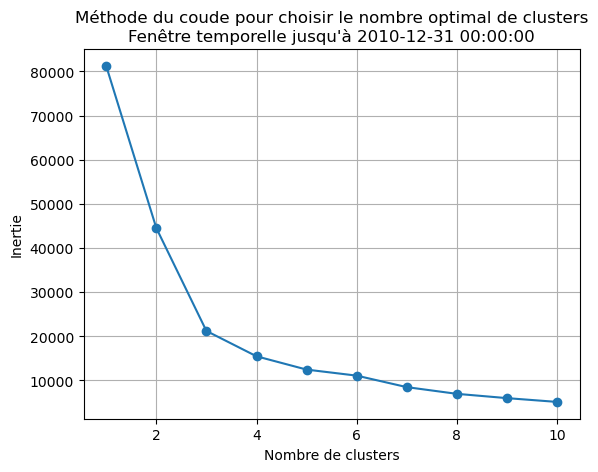

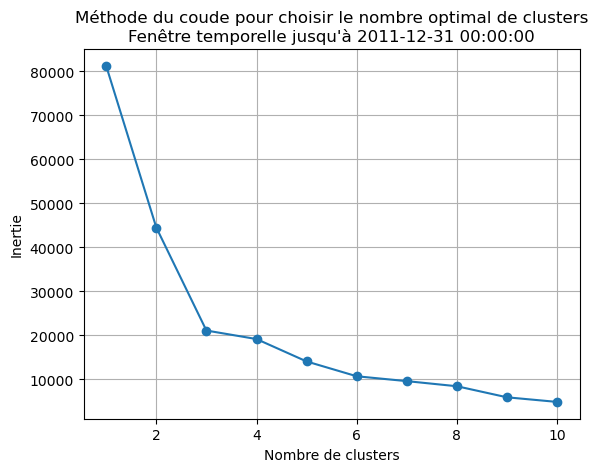

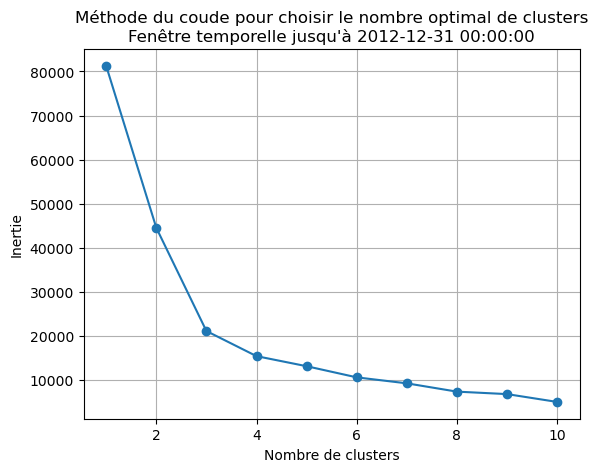

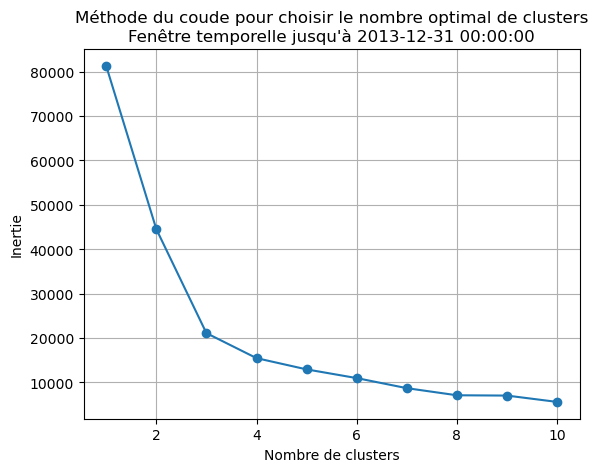

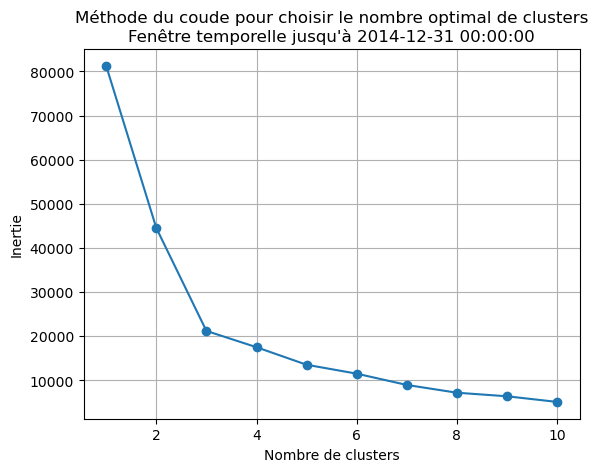

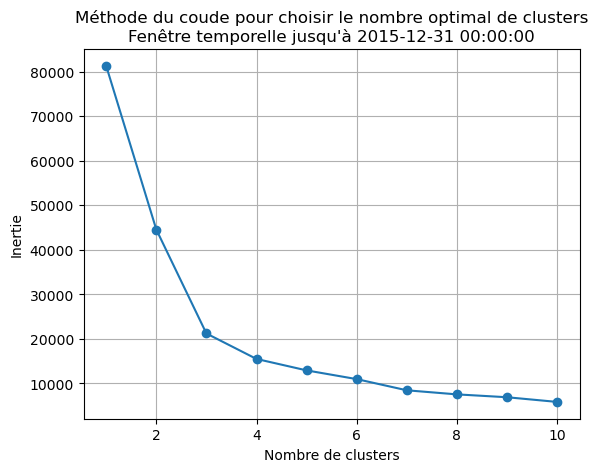

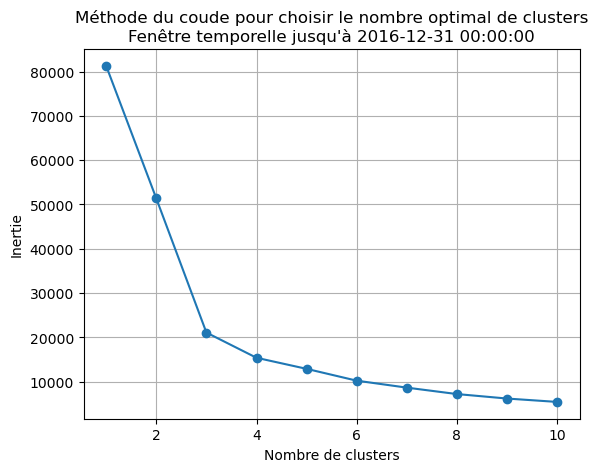

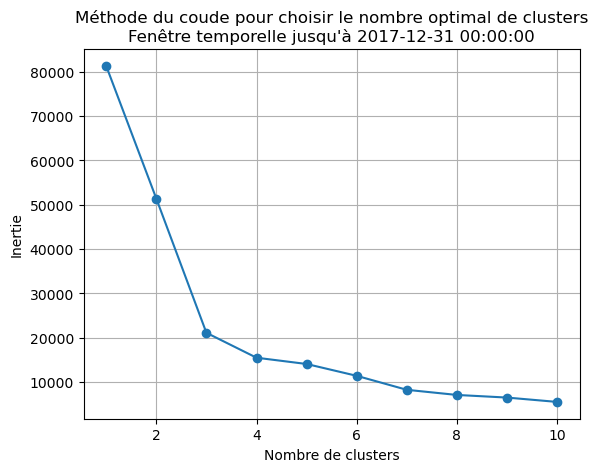

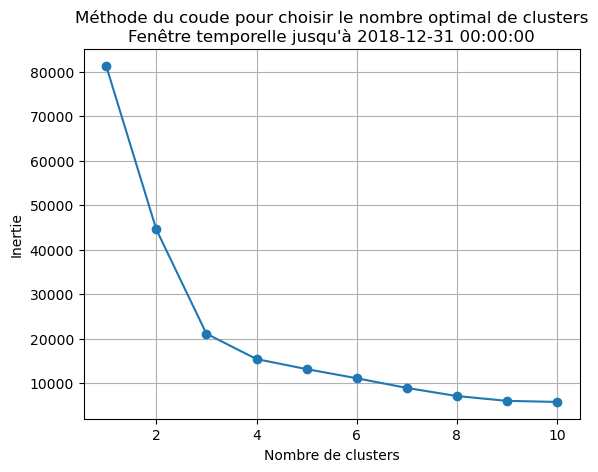

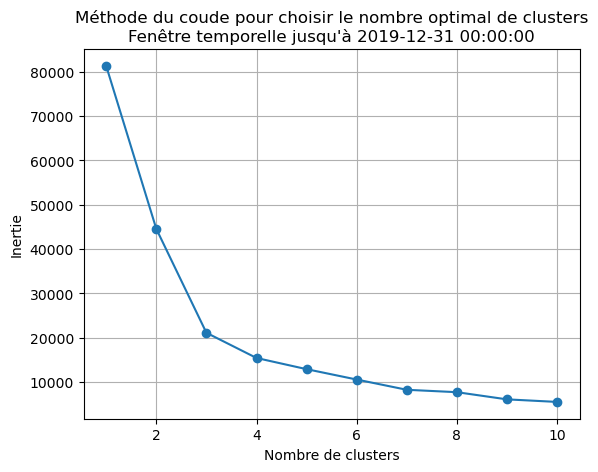

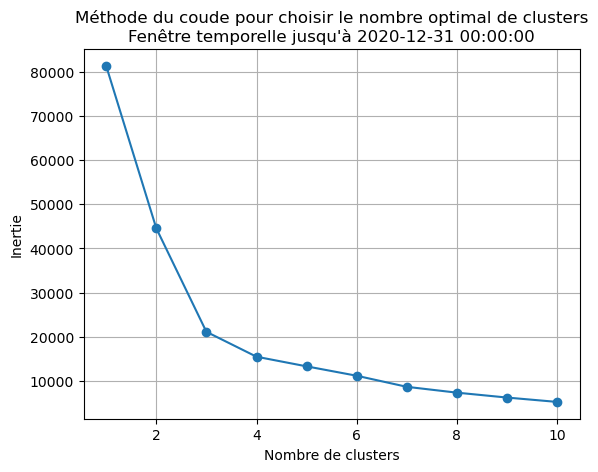

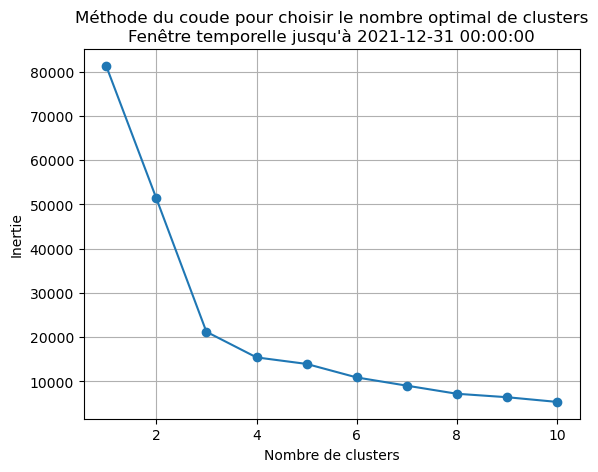

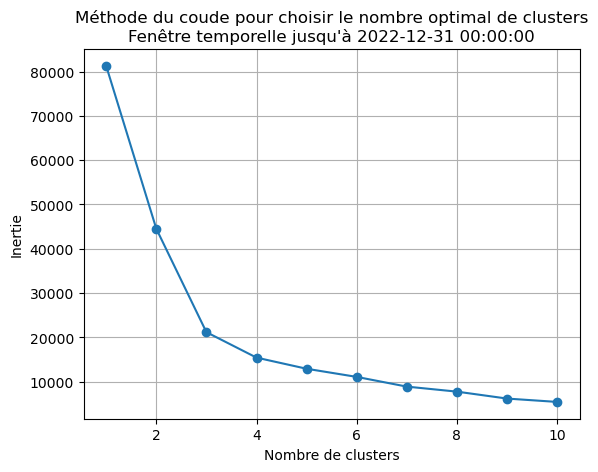

In [6]:
# Parcourir chaque modèle de clustering et trouver le meilleur k pour chaque fenêtre temporelle
for window_end, kmeans in cluster_models.items():
    agg_data = window_data.groupby('idEntreprise')[['PFL', 'Controverse']].mean()
    max_k = 10  # Définir le nombre maximal de clusters à tester
    inertias = []  # Liste pour stocker les inertias
    
    # Tester différents nombres de clusters (de 1 à max_k)
    for k in range(1, max_k + 1):
        # Créer un nouvel objet KMeans avec le nombre de clusters k
        kmeans_test = KMeans(n_clusters=k)
        # Entraîner le modèle de clustering sur les données agrégées
        kmeans_test.fit(agg_data)
        # Calculer l'inertie pour ce nombre de clusters
        inertia = kmeans_test.inertia_
        inertias.append(inertia)
    
    # Afficher le graphique de la méthode du coude pour choisir le nombre optimal de clusters
    plt.plot(range(1, max_k + 1), inertias, marker='o')
    plt.title(f"Méthode du coude pour choisir le nombre optimal de clusters\nFenêtre temporelle jusqu'à {window_end}")
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Inertie')
    plt.grid(True)
    plt.show()

Résultat flagrant : il faut prendre k = 3 pour tout les modèles

##### Méthode de la silouhette

La méthode de la silhouette est une technique d'évaluation de la qualité des clusters dans un algorithme de clustering. Elle mesure à quel point chaque point de données est similaire à son propre cluster (cohésion) par rapport aux autres clusters (séparation). En d'autres termes, elle permet de déterminer à quel point les clusters sont bien séparés les uns des autres.

Voici les étapes de la méthode de la silhouette :

    Calcul des distances intra-cluster (a) : Pour chaque point de données dans un cluster, calculez la distance moyenne entre ce point et tous les autres points du même cluster. Cela mesure à quel point le point est proche des autres points de son propre cluster.

    Calcul des distances inter-cluster (b) : Pour chaque point de données dans un cluster, calculez la distance moyenne entre ce point et tous les points des clusters voisins les plus proches. Cela mesure à quel point le point est éloigné des points des autres clusters.

    Calcul de la silhouette (s) : Pour chaque point de données, calculez la silhouette comme suit :
        Calculez la différence entre la distance moyenne intra-cluster (a) et la distance moyenne inter-cluster (b).
        Divisez cette différence par le maximum des deux distances (max(a, b)).
        La silhouette pour chaque point de données est donc (b - a) / max(a, b).

    Calcul de la silhouette moyenne : Calculez la silhouette moyenne pour tous les points de données d'un cluster. Cela donne une mesure globale de la qualité du clustering. La silhouette moyenne est comprise entre -1 et 1. Un score élevé indique que les clusters sont bien séparés, tandis qu'un score proche de zéro indique que les clusters se chevauchent.

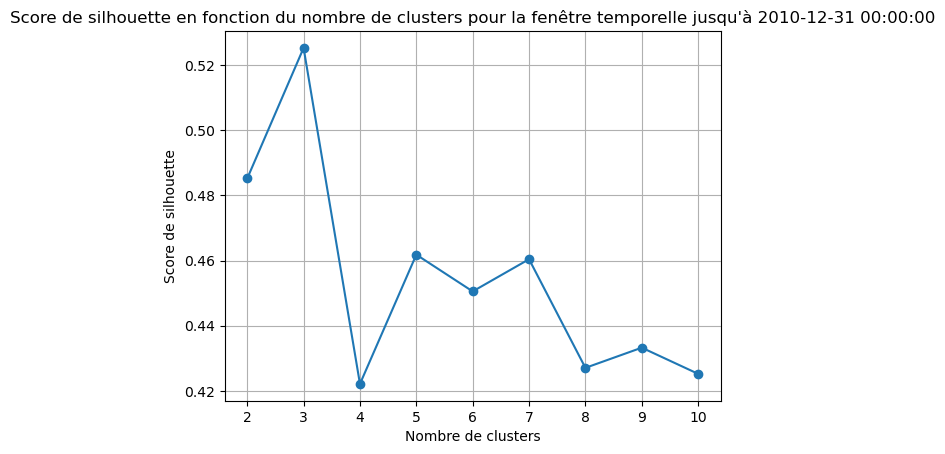

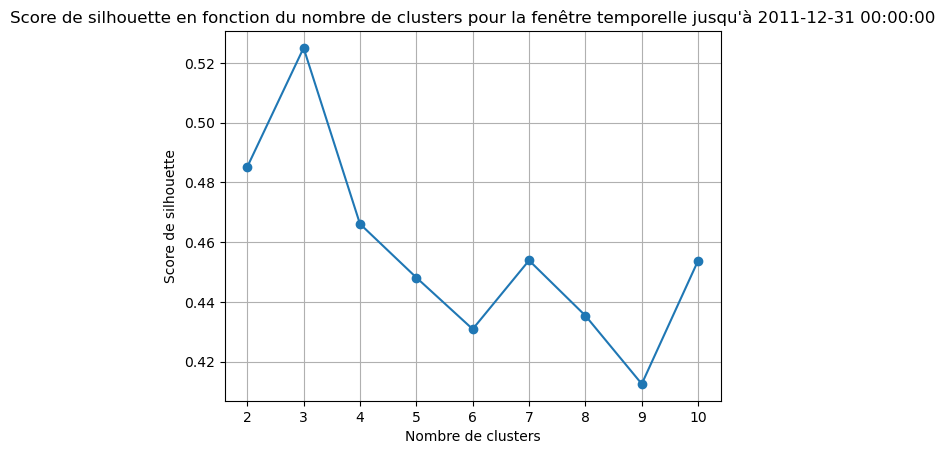

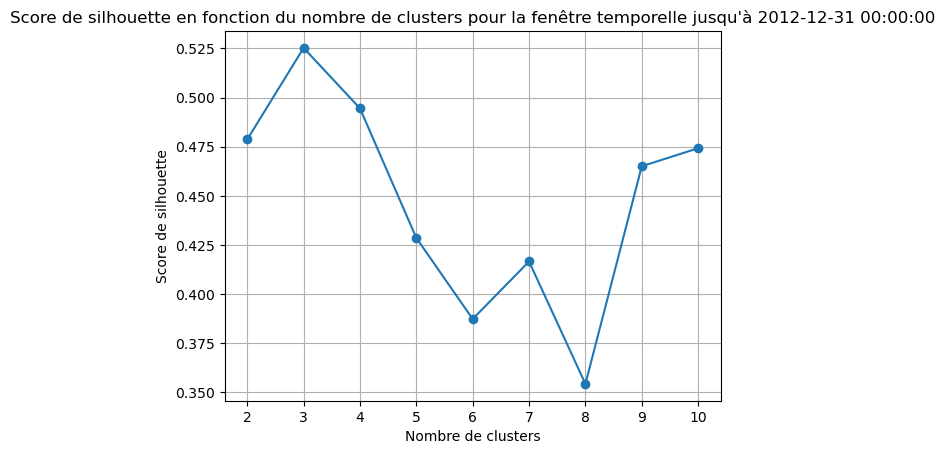

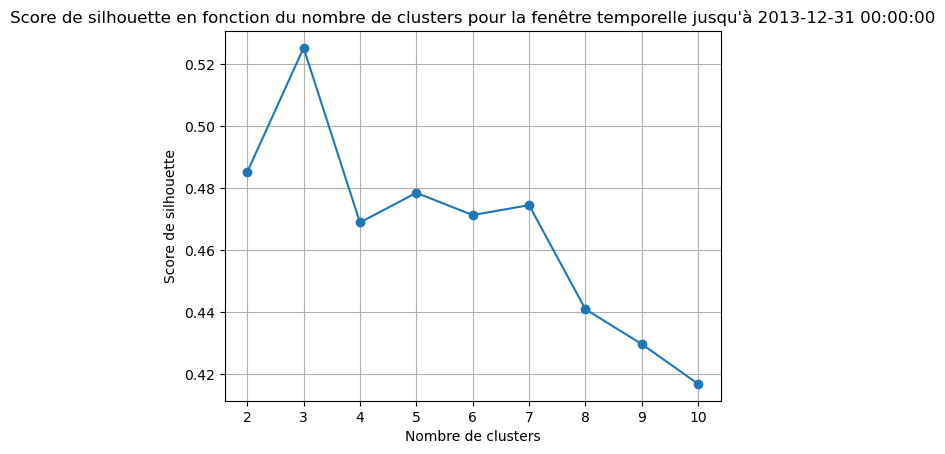

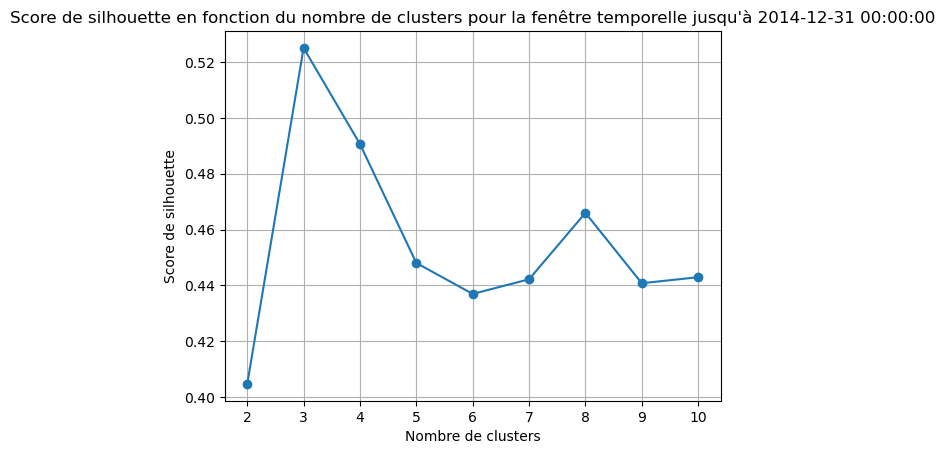

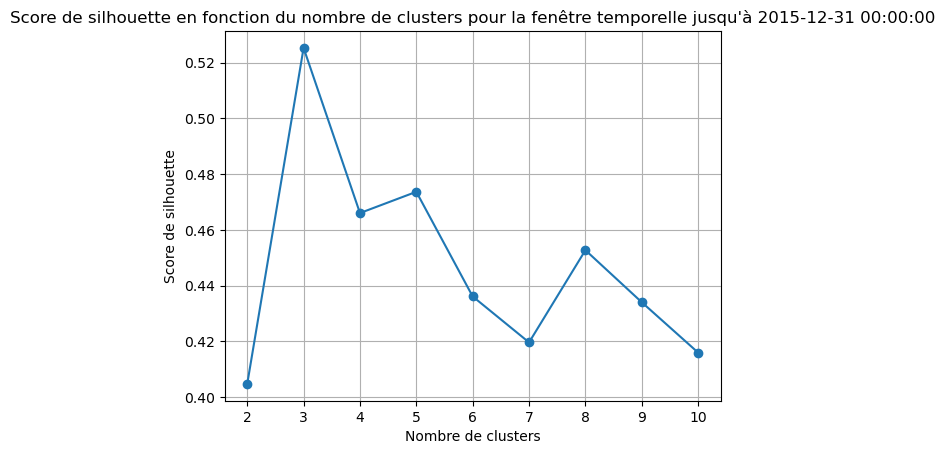

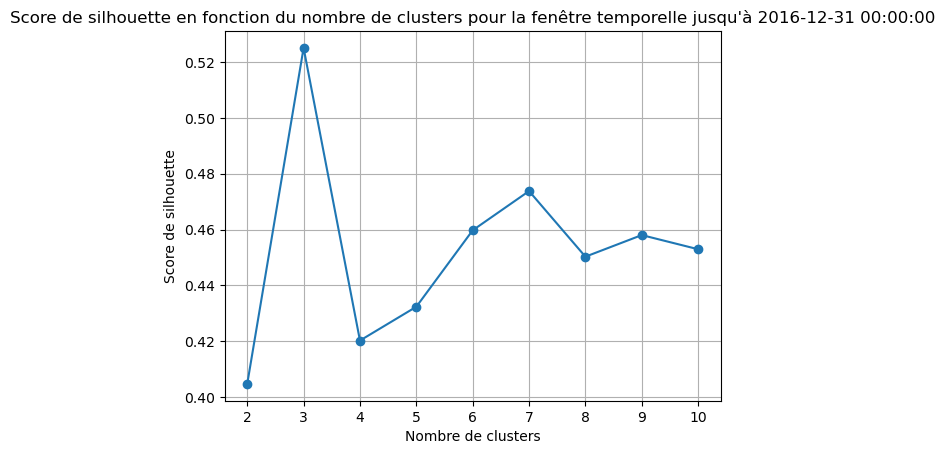

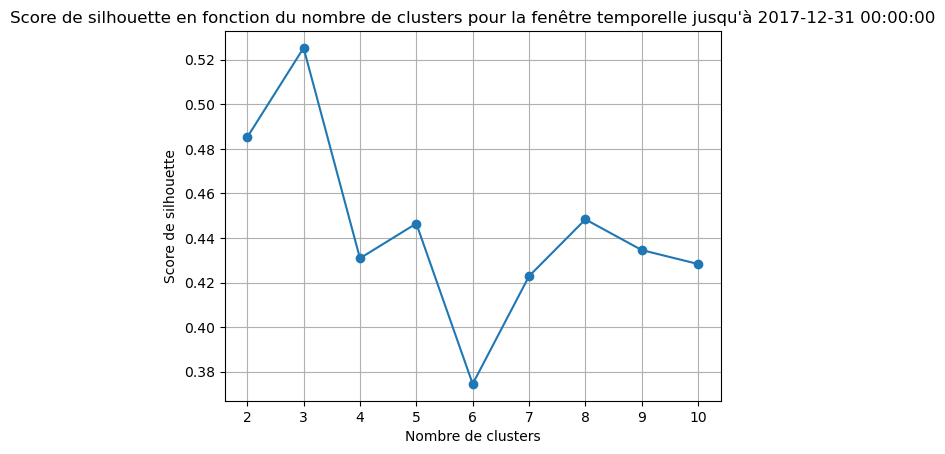

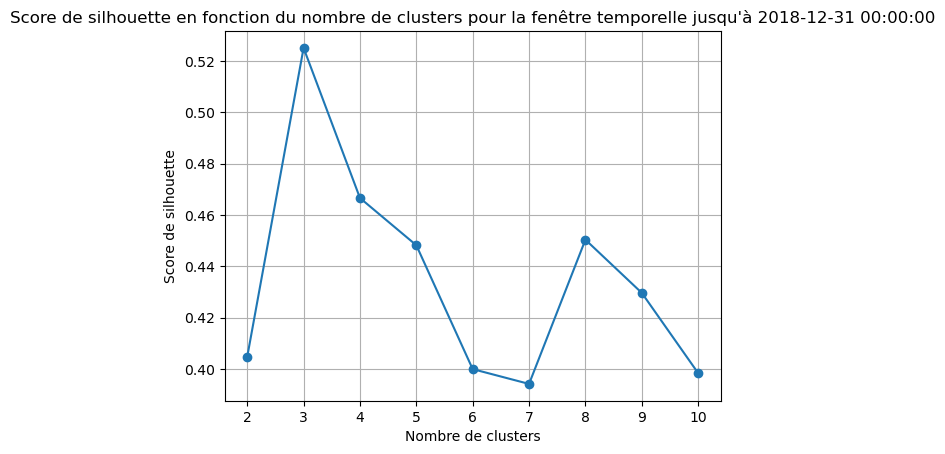

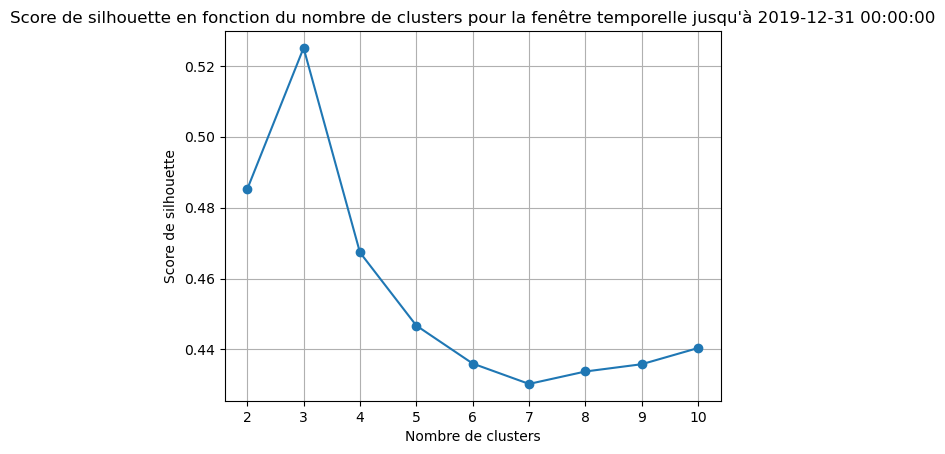

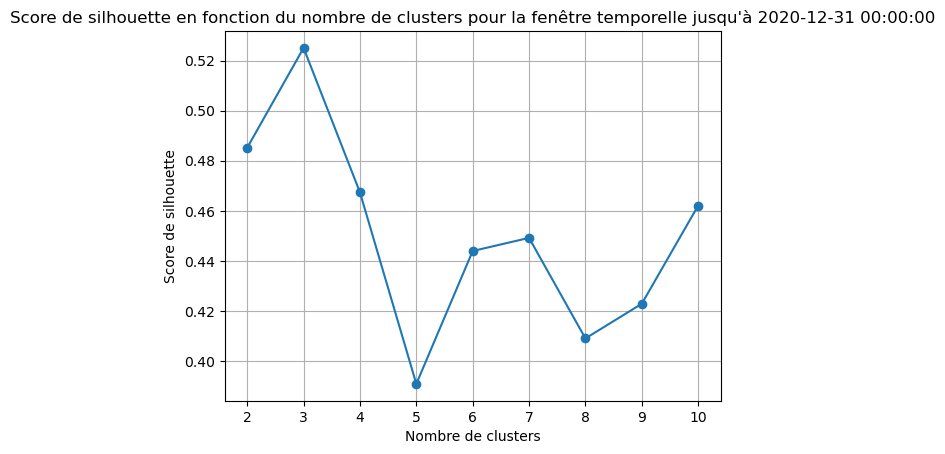

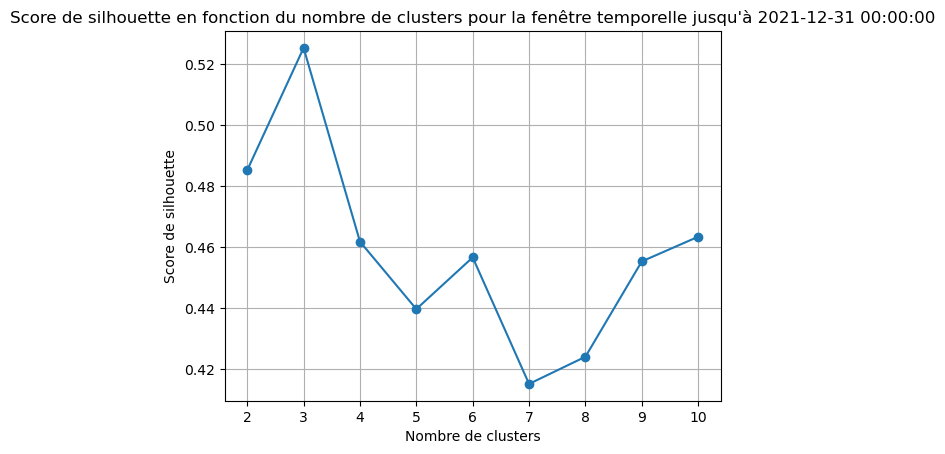

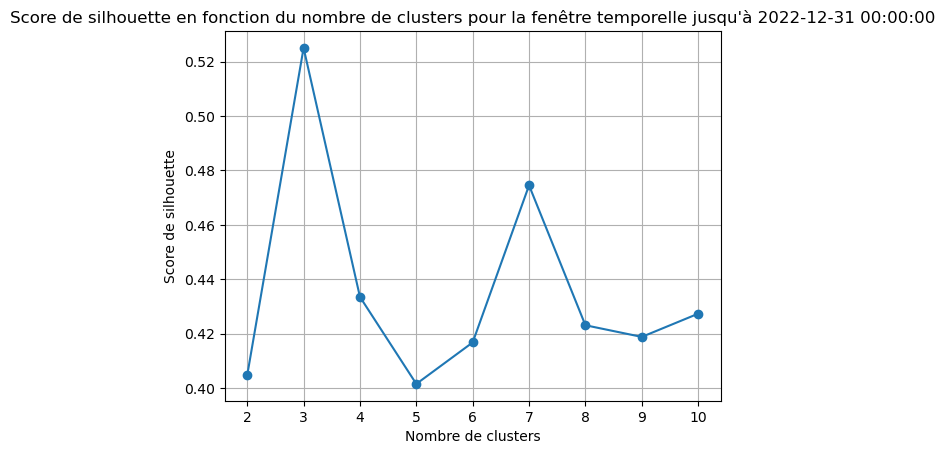

In [7]:
import matplotlib.pyplot as plt

# Parcourir chaque modèle de clustering et trouver le meilleur k pour chaque fenêtre temporelle
for window_end, kmeans in cluster_models.items():
    agg_data = window_data.groupby('idEntreprise')[['PFL', 'Controverse']].mean()
    max_k = 10  # Définir le nombre maximal de clusters à tester
    silhouette_scores = []  # Liste pour stocker les scores de silhouette
    
    # Tester différents nombres de clusters (de 2 à max_k)
    for k in range(2, max_k + 1):
        # Créer un nouvel objet KMeans avec le nombre de clusters k
        kmeans_test = KMeans(n_clusters=k)
        # Entraîner le modèle de clustering sur les données agrégées
        kmeans_test.fit(agg_data)
        # Calculer le score de silhouette pour ce nombre de clusters
        silhouette_avg = silhouette_score(agg_data, kmeans_test.labels_)
        silhouette_scores.append(silhouette_avg)
    
    # Afficher le graphique du score de silhouette en fonction du nombre de clusters
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    plt.title(f"Score de silhouette en fonction du nombre de clusters pour la fenêtre temporelle jusqu'à {window_end}")
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Score de silhouette')
    plt.grid(True)
    plt.show()

Résultat flagrant : il faut prendre k = 3 pour tout les modèles

##### Score de Calinski-Harabasz

Le score de Calinski-Harabasz, également appelé critère de variance, est une mesure de la qualité d'un clustering. Il évalue la compacité intra-cluster par rapport à la séparation inter-cluster. En d'autres termes, il mesure à quel point les clusters sont compacts et bien séparés les uns des autres.

Voici comment le score de Calinski-Harabasz est calculé :

    Calcul de la dispersion intra-cluster : Pour chaque cluster, calculez la dispersion intra-cluster, qui est la somme des carrés des distances entre chaque point de données du cluster et le centre de ce cluster (généralement le centroïde).

    Calcul de la dispersion inter-cluster : Calculez la dispersion inter-cluster, qui est la somme des carrés des distances entre les centres des clusters et le centre global de tous les points de données.

    Calcul du score de Calinski-Harabasz : Le score est calculé en divisant la dispersion intra-cluster par la dispersion inter-cluster, puis en multipliant le résultat par le nombre de clusters moins un (k - 1).

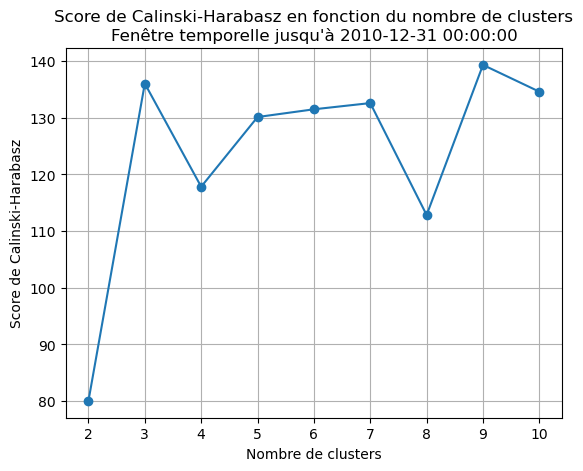

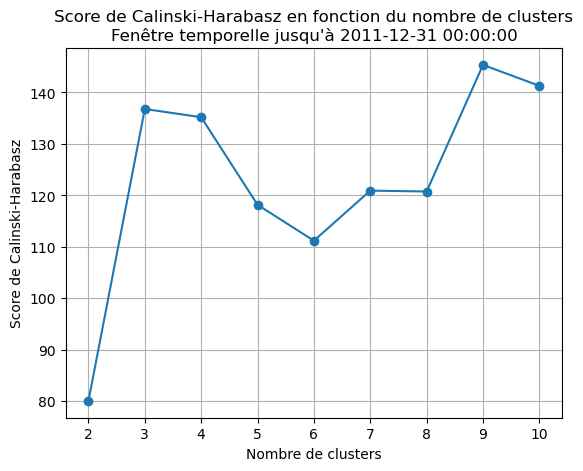

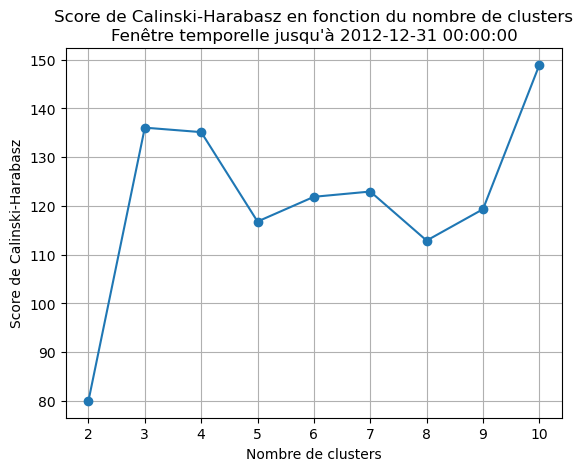

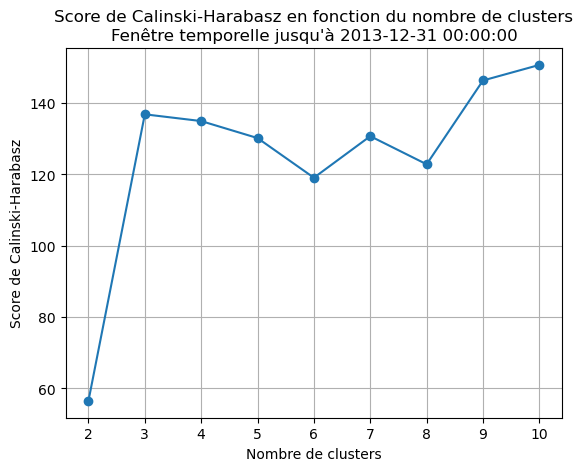

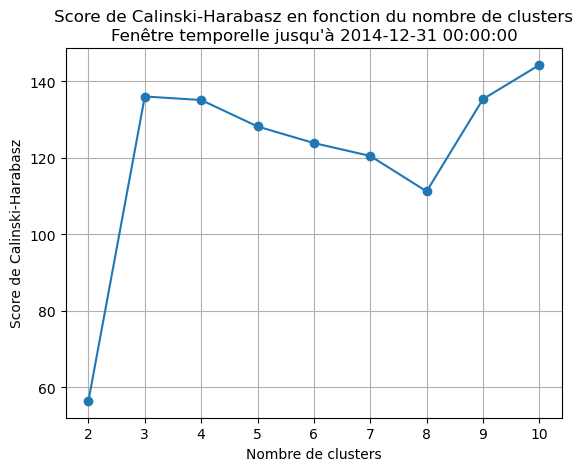

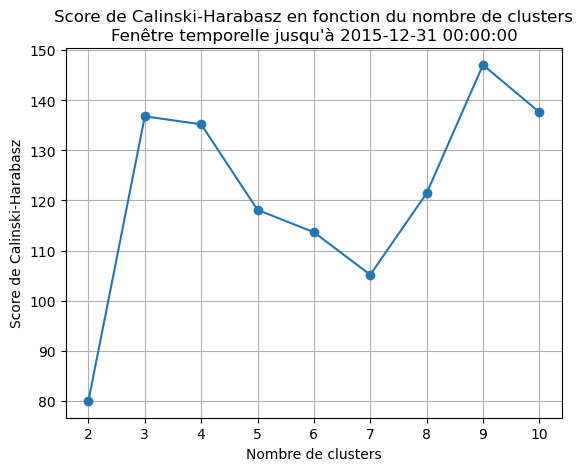

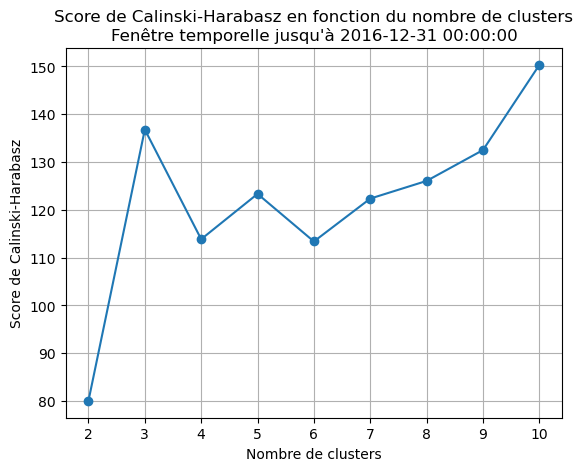

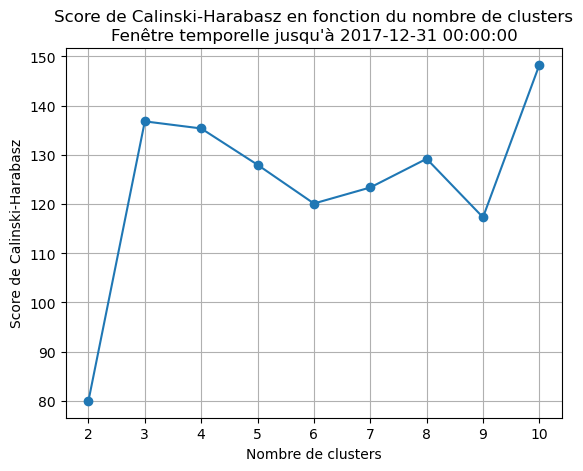

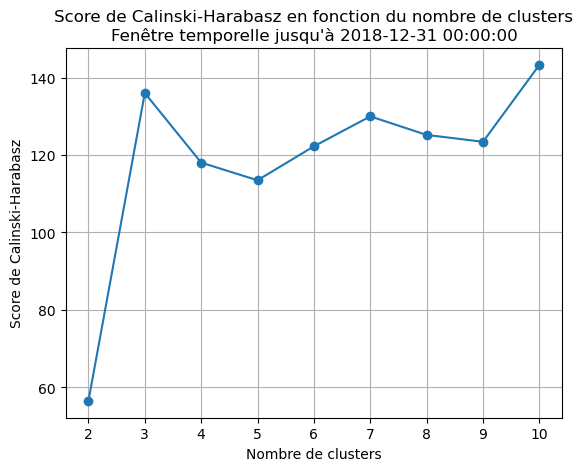

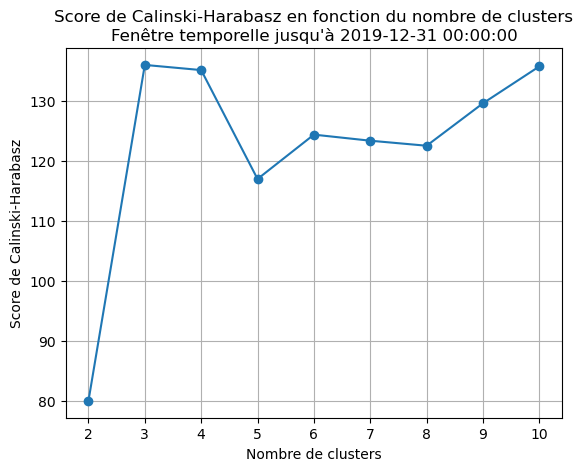

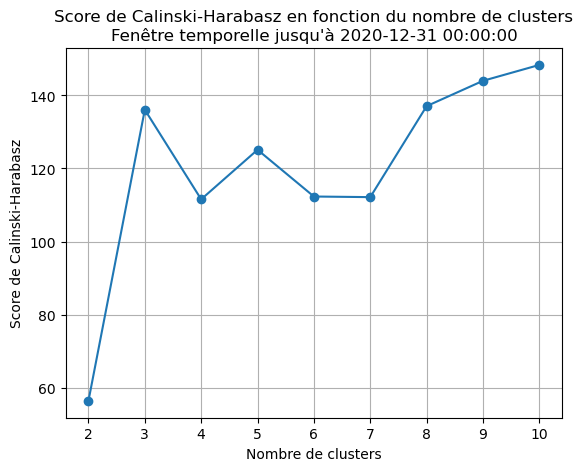

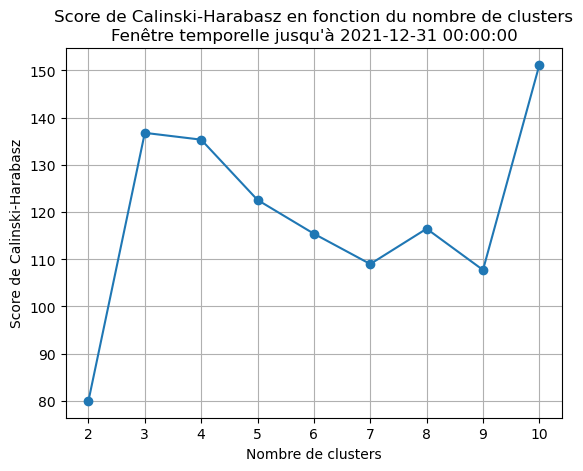

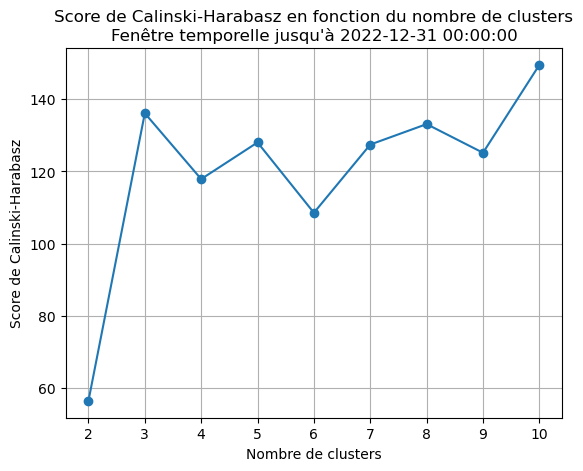

In [8]:
# Initialiser un dictionnaire pour stocker les scores de Calinski-Harabasz pour chaque fenêtre temporelle
ch_scores = {}

# Parcourir chaque modèle de clustering et trouver le meilleur k pour chaque fenêtre temporelle
for window_end, kmeans in cluster_models.items():
    agg_data = window_data.groupby('idEntreprise')[['PFL', 'Controverse']].mean()
    max_k = 10  # Définir le nombre maximal de clusters à tester
    ch_scores[window_end] = []  # Initialiser une liste pour stocker les scores de Calinski-Harabasz
    
    # Tester différents nombres de clusters (de 2 à max_k)
    for k in range(2, max_k + 1):
        # Créer un nouvel objet KMeans avec le nombre de clusters k
        kmeans_test = KMeans(n_clusters=k)
        # Entraîner le modèle de clustering sur les données agrégées
        kmeans_test.fit(agg_data)
        # Calculer le score de Calinski-Harabasz pour ce nombre de clusters
        ch_score = calinski_harabasz_score(agg_data, kmeans_test.labels_)
        ch_scores[window_end].append(ch_score)

# Afficher les graphiques des scores de Calinski-Harabasz en fonction du nombre de clusters pour chaque modèle
for window_end, scores in ch_scores.items():
    plt.plot(range(2, max_k + 1), scores, marker='o')
    plt.title(f"Score de Calinski-Harabasz en fonction du nombre de clusters\nFenêtre temporelle jusqu'à {window_end}")
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Score de Calinski-Harabasz')
    plt.grid(True)
    plt.show()

##### Conclusion : k = 3

Les méthodes du coude et de la silhouette montre que prendre k=3 est optimal pour tout les modèles de clusters. Le Score de Calinski-Harabasz lui est moins tranché, et propose des clusters à k=9 voir k=10. On prendra par soucis de simplicité k=3

#### Affichage des cluster pour la prédiction de 2019-01-01

In [9]:
df_cluster_1 = tables_cluster[0]
df_cluster_1

,idEntreprise,Date,ESG,PFL,Diff_z,Controverse
0,1,2009-01-01,60.866464,100.0,5.475597,2.983779e+01
1,1,2009-02-01,61.046910,100.0,5.339223,2.387023e+01
2,1,2009-03-01,61.223748,100.0,5.534291,1.909618e+01
3,1,2009-04-01,60.841493,100.0,5.639993,2.638806e+01
4,1,2009-05-01,60.590206,100.0,5.892612,4.333267e+01
...,...,...,...,...,...,...
16163,11620,2022-12-01,68.267457,100.0,-0.181934,2.158522e-08
16164,11620,2023-01-01,68.750719,100.0,-0.182209,1.726816e-08
16165,11620,2023-02-01,69.224316,100.0,-0.189905,1.381453e-08
16166,11620,2023-03-01,69.132885,100.0,-0.192519,1.105163e-08


In [10]:
df_cluster_2 = tables_cluster[1]
df_cluster_2

,idEntreprise,Date,ESG,PFL,Diff_z,Controverse
688,22,2009-01-01,86.414890,96.733427,0.362680,58.023783
689,22,2009-02-01,86.393779,96.733427,0.347337,46.419026
690,22,2009-03-01,86.379306,95.287728,0.239738,49.063495
691,22,2009-04-01,86.475351,95.287728,0.232189,58.597066
692,22,2009-05-01,86.543106,95.287728,0.198840,46.877652
...,...,...,...,...,...,...
15819,6658,2022-12-01,73.336592,84.998232,0.068968,76.307771
15820,6658,2023-01-01,72.686355,85.042195,0.127576,85.622068
15821,6658,2023-02-01,72.593282,85.042195,0.095782,88.680476
15822,6658,2023-03-01,72.747081,85.042195,0.071104,85.958797


In [11]:
df_cluster_3 = tables_cluster[2]
df_cluster_3

,idEntreprise,Date,ESG,PFL,Diff_z,Controverse
344,8,2009-01-01,55.996597,50.000000,-0.075484,17.161632
345,8,2009-02-01,56.296109,50.000000,-0.524792,24.840417
346,8,2009-03-01,56.311854,50.000000,-0.545910,19.872334
347,8,2009-04-01,56.882839,50.000000,-1.015869,15.897867
348,8,2009-05-01,56.886849,50.000000,-1.028567,12.718294
...,...,...,...,...,...,...
17023,18386,2022-12-01,49.680590,99.219927,2.391562,0.278300
17024,18386,2023-01-01,49.648089,99.219927,2.386211,0.222640
17025,18386,2023-02-01,49.616238,99.219927,2.347607,0.178112
17026,18386,2023-03-01,49.585025,99.219927,2.344902,0.142490


Maintenant qu'on est capable d'identifier des groupes d'entreprises homogènes pour une période donnée, comment savoir quels groupe a une forte ou faible communication environnemental ? 

Au lieu de prendre le score de communication environemental comme une variable quantitative, on la garde comme variable qualitative. Avec 3 niveaux de communication : 

Niveau 0 => faible communication

Niveau 1 => communication moyenne

Niveau 2 => forte communication

On pourra ensuite faire des régressions sur variables qualitatives => tout autre modèle. 

Seulement, comment attriber ces niveaux aux 3 clusters ? On prends la moyenne score Diff_z (qui représente le risque de greenwashing) par cluster, et on augmente la note de communication si la moyenne est élevé ? On pourrait peut être faire mieux encore, parce que le score Diff_z ne se base que sur les réputations, on pourrait inclure la controverse dans notre système d'attribution de note de communication environnemental.

Dans un premier temps, on va dire qu'on calcul la moyenne des différences entre le score de réputation et de controverse, entre 2009-01-01 et une date futur (date d'estimation du score de communication environnemental). Le cluster qui aura la moyenne la plus haute (ie avec un score de réputation élevé, et un score de controverse faible), représentera des entreprises qui sont bien vus, et aura la communication verte la plus faible (car pas besoin de communiquer, donc on va pas jetter de l'argent par les fenêtres)

In [12]:
# Définir une fonction pour calculer la moyenne de la différence entre PFL et Controverse jusqu'à une date future spécifiée
def calculate_mean_difference(df_cluster):
    # Convertir la colonne "Date" en format datetime en utilisant .loc pour éviter l'avertissement SettingWithCopyWarning
    df_cluster.loc[:, 'Date'] = pd.to_datetime(df_cluster['Date'])

    # Spécifier la date future
    date_future = "2023-04-01"

    # Filtrer les données pour inclure uniquement les dates comprises entre le 1er janvier 2009 et la date future spécifiée
    filtered_data = df_cluster[(df_cluster['Date'] >= '2009-01-01') & (df_cluster['Date'] <= date_future)].copy()

    # Calculer la différence entre les colonnes "PFL" et "Controverse" en utilisant .loc pour éviter l'avertissement SettingWithCopyWarning
    filtered_data.loc[:, 'Difference'] = filtered_data['PFL'] - filtered_data['Controverse']

    # Calculer la moyenne de la différence
    mean_difference = filtered_data['Difference'].mean()

    print("Moyenne de la différence entre PFL et Controverse jusqu'à la date future spécifiée:", mean_difference)

    return mean_difference

# Définir une fonction pour attribuer les scores en fonction des moyennes de différence
def attribution_score(dictionnaire_score):
    # Ordonner le dictionnaire de score en fonction de la moyenne de la différence entre PFL et Controverse
    sorted_scores = sorted(dictionnaire_score.items(), key=lambda x: x[1], reverse=True)

    # Créer un dictionnaire pour stocker les scores attribués
    scores_attribues = {}

    # Attribuer les scores
    for idx, (cluster, _) in enumerate(sorted_scores):
        scores_attribues[cluster] = idx

    return scores_attribues

dictionnaire_score = {
    'Cluster 1': calculate_mean_difference(df_cluster_1),
    'Cluster 2': calculate_mean_difference(df_cluster_2),
    'Cluster 3': calculate_mean_difference(df_cluster_3)
}

scores_attribues = attribution_score(dictionnaire_score)
print("Scores attribués :", scores_attribues)


Moyenne de la différence entre PFL et Controverse jusqu'à la date future spécifiée: 74.13395067294636
Moyenne de la différence entre PFL et Controverse jusqu'à la date future spécifiée: 29.12755536654056
Moyenne de la différence entre PFL et Controverse jusqu'à la date future spécifiée: 48.35288274999423
Scores attribués : {'Cluster 1': 0, 'Cluster 3': 1, 'Cluster 2': 2}


On a donc qu'au 1er avril 2023, les entreprises appartenant au cluster 1 sont celles qui communiquent le moins. Les entreprises appartenant au cluster 2 sont celles qui communiquent moyennement, et les entreprises appartenant au cluster 3 sont celles qui communiquent le plus. On essaye d'étendre ces résultats à toutes les périodes :

#### Généralisation du code

On répète cette méthode pour toutes les dates possibles, et ainsi récupérer un score de communication environemental pour chaque période :

In [13]:
scored_rows = {}

# Exemple d'utilisation : afficher les entreprises dans le même cluster pour une date spécifique
def predict_clusters_at_date(date, cluster_models):
    clusters = {}
    for window_end, kmeans in cluster_models.items():
        if date <= window_end:
            # Sélectionner les données agrégées pour la date spécifique
            agg_data_date = df1[df1['Date'] == date].groupby('idEntreprise')[['PFL', 'Controverse']].mean()
            # Prédire les clusters pour les données agrégées de la date spécifique
            predicted_cluster_labels = kmeans.predict(agg_data_date)
            
            # Créer un dictionnaire pour stocker les indices des entreprises par cluster
            clusters = {}
            for i, label in enumerate(predicted_cluster_labels):
                if label not in clusters:
                    clusters[label] = []
                clusters[label].append(agg_data_date.index[i])
                
            return clusters

# Modifier la fonction create_tables_clusters pour ajouter une colonne "Score" à chaque table de données
def create_tables_clusters(clusters):
    tables_cluster = {}
    nombre_de_donnees_par_table = {}

    for cluster, entreprises in clusters.items():
        # Sélectionner les lignes des entreprises dans le cluster actuel
        entreprises_cluster = df1[df1['idEntreprise'].isin(entreprises)]
        # Ajouter une colonne "Score" initialisée à NaN
        entreprises_cluster['Score'] = np.nan
        # Stocker la table de données pour ce cluster
        tables_cluster[cluster] = entreprises_cluster
        # Calculer le nombre de données dans cette table
        nombre_de_donnees_par_table[cluster] = len(entreprises_cluster)

    return tables_cluster, nombre_de_donnees_par_table

# Définir une fonction pour calculer la moyenne de la différence entre PFL et Controverse jusqu'à une date future spécifiée
def calculate_mean_difference(df_cluster, date_future):
    # Convertir la colonne "Date" en format datetime en utilisant .loc pour éviter l'avertissement SettingWithCopyWarning
    df_cluster.loc[:, 'Date'] = pd.to_datetime(df_cluster['Date'])

    # Filtrer les données pour inclure uniquement les dates comprises entre le 1er janvier 2009 et la date future spécifiée
    filtered_data = df_cluster[(df_cluster['Date'] >= '2009-01-01') & (df_cluster['Date'] <= date_future)].copy()

    # Calculer la différence entre les colonnes "PFL" et "Controverse" en utilisant .loc pour éviter l'avertissement SettingWithCopyWarning
    filtered_data.loc[:, 'Difference'] = filtered_data['PFL'] - filtered_data['Controverse']

    # Calculer la moyenne de la différence
    mean_difference = filtered_data['Difference'].mean()

    return mean_difference

# Définir une fonction pour attribuer les scores en fonction des moyennes de différence
def attribution_score(dictionnaire_score):
    # Ordonner le dictionnaire de score en fonction de la moyenne de la différence entre PFL et Controverse
    sorted_scores = sorted(dictionnaire_score.items(), key=lambda x: x[1], reverse=True)

    # Créer un dictionnaire pour stocker les scores attribués
    scores_attribues = {}

    # Attribuer les scores
    for idx, (cluster, _) in enumerate(sorted_scores):
        scores_attribues[cluster] = idx

    return scores_attribues


# Spécifier les dates futures
dates_future = pd.date_range(start='2009-01-01', end='2022-12-01', freq='MS')

# Boucle sur toutes les dates futures
for date_future in dates_future:
    date_future_str = date_future.strftime('%Y-%m-%d')
    print(f"Date future: {date_future_str}")

    # Prédire les clusters pour la date spécifique
    clusters = predict_clusters_at_date(date_future, cluster_models)

    # Créer les tables de données pour chaque cluster avec la colonne "Score"
    tables_cluster, nombre_de_donnees_par_table = create_tables_clusters(clusters)

    # Calculer la moyenne de la différence pour chaque cluster
    mean_difference_per_cluster = {}
    for cluster, _ in clusters.items():
        df_cluster = tables_cluster[cluster]  # Accéder au DataFrame du cluster
        mean_difference_per_cluster[cluster] = calculate_mean_difference(df_cluster, date_future)

    # Attribuer les scores en fonction des moyennes de différence
    scores_per_cluster = attribution_score(mean_difference_per_cluster)

    # Créer les tables de données pour chaque cluster
    tables_cluster, nombre_de_donnees_par_table = create_tables_clusters(clusters)

    # Afficher les tables de données, le nombre de données et le score pour chaque cluster
    for cluster, table in tables_cluster.items():
    
        # Itérer sur chaque ligne du DataFrame du cluster
        for idx, row in table.iterrows():
            # Vérifier si la date de la ligne correspond à la date future
            if row['Date'] == date_future:
                # Attribuer le score à cette ligne
                table.at[idx, 'Score'] = scores_per_cluster[cluster]
                scored_rows[idx] = table.loc[idx]            

        print(f"Cluster {cluster}:")
        print(table)
        print(f"Nombre d'entreprises dans le cluster : {nombre_de_donnees_par_table[cluster] / 172}")  # Nombre d'entreprises = nombre de données / 172
        print(f"Score attribué : {scores_per_cluster[cluster]}\n")

scored_df = pd.DataFrame.from_dict(scored_rows, orient='index')
scored_df


Date future: 2009-01-01


/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
14615          6627 2022-12-01  77.739474   88.276916  1.531107    97.294486   
14616          6627 2023-01-01  78.557797   89.437388  1.508490    99.293206   
14617          6627 2023-02-01  78.359820   87.368761  1.358488    98.327377   
14618          6627 2023-03-01  78.896217   88.290630  1.267402    99.327973   
14619          6627 2023-04-01  79.339156   88.826322  1.175911    97.569903   

       Score  
0        0.0 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15475          6653 2022-12-01  72.790934   97.982527  0.479186    23.998295   
15476          6653 2023-01-01  72.829853   97.982527  0.429798    30.309747   
15477          6653 2023-02-01  73.561613   98.226737  0.394296    24.247798   
15478          6653 2023-03-01  73.220110   94.124487  0.272875    41.620461   
15479          6653 2023-04-01  73.630436   94.124487  0.245010    33.296368   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15475          6653 2022-12-01  72.790934   97.982527  0.479186    23.998295   
15476          6653 2023-01-01  72.829853   97.982527  0.429798    30.309747   
15477          6653 2023-02-01  73.561613   98.226737  0.394296    24.247798   
15478          6653 2023-03-01  73.220110   94.124487  0.272875    41.620461   
15479          6653 2023-04-01  73.630436   94.124487  0.245010    33.296368   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.00000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.00000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.00000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.00000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.00000  5.892612    43.332669   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
0        NaN  
1        N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15303          6652 2022-12-01  72.937329   91.484314 -0.166821     6.367691   
15304          6652 2023-01-01  73.015481   91.770010 -0.164392     5.094153   
15305          6652 2023-02-01  73.027905   91.770010 -0.172767     4.075322   
15306          6652 2023-03-01  73.236033   92.520381 -0.169486     3.260258   
15307          6652 2023-04-01  73.366419   92.633652 -0.172804     2.608206   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.00000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.00000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.00000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.00000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.00000  5.892612    43.332669   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
0        NaN  
1        N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.00000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.00000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.00000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.00000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.00000  5.892612    43.332669   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
0        NaN  
1        N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15475          6653 2022-12-01  72.790934   97.982527  0.479186    23.998295   
15476          6653 2023-01-01  72.829853   97.982527  0.429798    30.309747   
15477          6653 2023-02-01  73.561613   98.226737  0.394296    24.247798   
15478          6653 2023-03-01  73.220110   94.124487  0.272875    41.620461   
15479          6653 2023-04-01  73.630436   94.124487  0.245010    33.296368   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.00000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.00000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.00000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.00000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.00000  5.892612    43.332669   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
0        NaN  
1        N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15303          6652 2022-12-01  72.937329   91.484314 -0.166821     6.367691   
15304          6652 2023-01-01  73.015481   91.770010 -0.164392     5.094153   
15305          6652 2023-02-01  73.027905   91.770010 -0.172767     4.075322   
15306          6652 2023-03-01  73.236033   92.520381 -0.169486     3.260258   
15307          6652 2023-04-01  73.366419   92.633652 -0.172804     2.608206   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15303          6652 2022-12-01  72.937329   91.484314 -0.166821     6.367691   
15304          6652 2023-01-01  73.015481   91.770010 -0.164392     5.094153   
15305          6652 2023-02-01  73.027905   91.770010 -0.172767     4.075322   
15306          6652 2023-03-01  73.236033   92.520381 -0.169486     3.260258   
15307          6652 2023-04-01  73.366419   92.633652 -0.172804     2.608206   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
172               4 2009-01-01  57.455054  100.00000  9.404450    25.226747   
173               4 2009-02-01  57.426786  100.00000  9.322334    20.181397   
174               4 2009-03-01  57.399084  100.00000  9.808397    16.145118   
175               4 2009-04-01  57.371935  100.00000  9.402321    12.916094   
176               4 2009-05-01  57.345330  100.00000  9.517171    10.332875   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
172      NaN  
173      N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
172               4 2009-01-01  57.455054  100.00000  9.404450    25.226747   
173               4 2009-02-01  57.426786  100.00000  9.322334    20.181397   
174               4 2009-03-01  57.399084  100.00000  9.808397    16.145118   
175               4 2009-04-01  57.371935  100.00000  9.402321    12.916094   
176               4 2009-05-01  57.345330  100.00000  9.517171    10.332875   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
172      NaN  
173      N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
172               4 2009-01-01  57.455054  100.00000  9.404450    25.226747   
173               4 2009-02-01  57.426786  100.00000  9.322334    20.181397   
174               4 2009-03-01  57.399084  100.00000  9.808397    16.145118   
175               4 2009-04-01  57.371935  100.00000  9.402321    12.916094   
176               4 2009-05-01  57.345330  100.00000  9.517171    10.332875   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
172      NaN  
173      N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
172               4 2009-01-01  57.455054  100.00000  9.404450    25.226747   
173               4 2009-02-01  57.426786  100.00000  9.322334    20.181397   
174               4 2009-03-01  57.399084  100.00000  9.808397    16.145118   
175               4 2009-04-01  57.371935  100.00000  9.402321    12.916094   
176               4 2009-05-01  57.345330  100.00000  9.517171    10.332875   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
172      NaN  
173      N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
172               4 2009-01-01  57.455054  100.00000  9.404450    25.226747   
173               4 2009-02-01  57.426786  100.00000  9.322334    20.181397   
174               4 2009-03-01  57.399084  100.00000  9.808397    16.145118   
175               4 2009-04-01  57.371935  100.00000  9.402321    12.916094   
176               4 2009-05-01  57.345330  100.00000  9.517171    10.332875   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
172      NaN  
173      N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.00000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.00000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.00000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.00000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.00000  5.892612    43.332669   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
0        NaN  
1        N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.00000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.00000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.00000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.00000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.00000  5.892612    43.332669   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
0        NaN  
1        N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15303          6652 2022-12-01  72.937329   91.484314 -0.166821     6.367691   
15304          6652 2023-01-01  73.015481   91.770010 -0.164392     5.094153   
15305          6652 2023-02-01  73.027905   91.770010 -0.172767     4.075322   
15306          6652 2023-03-01  73.236033   92.520381 -0.169486     3.260258   
15307          6652 2023-04-01  73.366419   92.633652 -0.172804     2.608206   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
172               4 2009-01-01  57.455054  100.00000  9.404450    25.226747   
173               4 2009-02-01  57.426786  100.00000  9.322334    20.181397   
174               4 2009-03-01  57.399084  100.00000  9.808397    16.145118   
175               4 2009-04-01  57.371935  100.00000  9.402321    12.916094   
176               4 2009-05-01  57.345330  100.00000  9.517171    10.332875   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
172      NaN  
173      N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
172               4 2009-01-01  57.455054  100.00000  9.404450    25.226747   
173               4 2009-02-01  57.426786  100.00000  9.322334    20.181397   
174               4 2009-03-01  57.399084  100.00000  9.808397    16.145118   
175               4 2009-04-01  57.371935  100.00000  9.402321    12.916094   
176               4 2009-05-01  57.345330  100.00000  9.517171    10.332875   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
172      NaN  
173      N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
172               4 2009-01-01  57.455054  100.00000  9.404450    25.226747   
173               4 2009-02-01  57.426786  100.00000  9.322334    20.181397   
174               4 2009-03-01  57.399084  100.00000  9.808397    16.145118   
175               4 2009-04-01  57.371935  100.00000  9.402321    12.916094   
176               4 2009-05-01  57.345330  100.00000  9.517171    10.332875   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
172      NaN  
173      N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
172               4 2009-01-01  57.455054  100.00000  9.404450    25.226747   
173               4 2009-02-01  57.426786  100.00000  9.322334    20.181397   
174               4 2009-03-01  57.399084  100.00000  9.808397    16.145118   
175               4 2009-04-01  57.371935  100.00000  9.402321    12.916094   
176               4 2009-05-01  57.345330  100.00000  9.517171    10.332875   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
172      NaN  
173      N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.00000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.00000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.00000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.00000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.00000  5.892612    43.332669   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
0        NaN  
1        N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.00000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.00000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.00000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.00000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.00000  5.892612    43.332669   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
0        NaN  
1        N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.00000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.00000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.00000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.00000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.00000  5.892612    43.332669   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
0        NaN  
1        N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.00000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.00000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.00000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.00000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.00000  5.892612    43.332669   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
0        NaN  
1        N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.00000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.00000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.00000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.00000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.00000  5.892612    43.332669   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
0        NaN  
1        N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.00000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.00000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.00000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.00000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.00000  5.892612    43.332669   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
0        NaN  
1        N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
172               4 2009-01-01  57.455054  100.00000  9.404450    25.226747   
173               4 2009-02-01  57.426786  100.00000  9.322334    20.181397   
174               4 2009-03-01  57.399084  100.00000  9.808397    16.145118   
175               4 2009-04-01  57.371935  100.00000  9.402321    12.916094   
176               4 2009-05-01  57.345330  100.00000  9.517171    10.332875   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
172      NaN  
173      N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
172               4 2009-01-01  57.455054  100.00000  9.404450    25.226747   
173               4 2009-02-01  57.426786  100.00000  9.322334    20.181397   
174               4 2009-03-01  57.399084  100.00000  9.808397    16.145118   
175               4 2009-04-01  57.371935  100.00000  9.402321    12.916094   
176               4 2009-05-01  57.345330  100.00000  9.517171    10.332875   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
172      NaN  
173      N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15475          6653 2022-12-01  72.790934   97.982527  0.479186    23.998295   
15476          6653 2023-01-01  72.829853   97.982527  0.429798    30.309747   
15477          6653 2023-02-01  73.561613   98.226737  0.394296    24.247798   
15478          6653 2023-03-01  73.220110   94.124487  0.272875    41.620461   
15479          6653 2023-04-01  73.630436   94.124487  0.245010    33.296368   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
172               4 2009-01-01  57.455054  100.00000  9.404450    25.226747   
173               4 2009-02-01  57.426786  100.00000  9.322334    20.181397   
174               4 2009-03-01  57.399084  100.00000  9.808397    16.145118   
175               4 2009-04-01  57.371935  100.00000  9.402321    12.916094   
176               4 2009-05-01  57.345330  100.00000  9.517171    10.332875   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
172      NaN  
173      N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15475          6653 2022-12-01  72.790934   97.982527  0.479186    23.998295   
15476          6653 2023-01-01  72.829853   97.982527  0.429798    30.309747   
15477          6653 2023-02-01  73.561613   98.226737  0.394296    24.247798   
15478          6653 2023-03-01  73.220110   94.124487  0.272875    41.620461   
15479          6653 2023-04-01  73.630436   94.124487  0.245010    33.296368   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
172               4 2009-01-01  57.455054  100.00000  9.404450    25.226747   
173               4 2009-02-01  57.426786  100.00000  9.322334    20.181397   
174               4 2009-03-01  57.399084  100.00000  9.808397    16.145118   
175               4 2009-04-01  57.371935  100.00000  9.402321    12.916094   
176               4 2009-05-01  57.345330  100.00000  9.517171    10.332875   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
172      NaN  
173      N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
172               4 2009-01-01  57.455054  100.00000  9.404450    25.226747   
173               4 2009-02-01  57.426786  100.00000  9.322334    20.181397   
174               4 2009-03-01  57.399084  100.00000  9.808397    16.145118   
175               4 2009-04-01  57.371935  100.00000  9.402321    12.916094   
176               4 2009-05-01  57.345330  100.00000  9.517171    10.332875   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
172      NaN  
173      N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
172               4 2009-01-01  57.455054  100.00000  9.404450    25.226747   
173               4 2009-02-01  57.426786  100.00000  9.322334    20.181397   
174               4 2009-03-01  57.399084  100.00000  9.808397    16.145118   
175               4 2009-04-01  57.371935  100.00000  9.402321    12.916094   
176               4 2009-05-01  57.345330  100.00000  9.517171    10.332875   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
172      NaN  
173      N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
11175           832 2022-12-01  74.644138   85.711999  0.631962    95.829313   
11176           832 2023-01-01  74.974743   85.929618  0.571890    86.618801   
11177           832 2023-02-01  75.224969   86.315783  0.560884    93.066440   
11178           832 2023-03-01  74.786563   84.373292  0.478042    96.334506   
11179           832 2023-04-01  75.109092   85.030646  0.451757    90.533596   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
11175           832 2022-12-01  74.644138   85.711999  0.631962    95.829313   
11176           832 2023-01-01  74.974743   85.929618  0.571890    86.618801   
11177           832 2023-02-01  75.224969   86.315783  0.560884    93.066440   
11178           832 2023-03-01  74.786563   84.373292  0.478042    96.334506   
11179           832 2023-04-01  75.109092   85.030646  0.451757    90.533596   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
11175           832 2022-12-01  74.644138   85.711999  0.631962    95.829313   
11176           832 2023-01-01  74.974743   85.929618  0.571890    86.618801   
11177           832 2023-02-01  75.224969   86.315783  0.560884    93.066440   
11178           832 2023-03-01  74.786563   84.373292  0.478042    96.334506   
11179           832 2023-04-01  75.109092   85.030646  0.451757    90.533596   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
11175           832 2022-12-01  74.644138   85.711999  0.631962    95.829313   
11176           832 2023-01-01  74.974743   85.929618  0.571890    86.618801   
11177           832 2023-02-01  75.224969   86.315783  0.560884    93.066440   
11178           832 2023-03-01  74.786563   84.373292  0.478042    96.334506   
11179           832 2023-04-01  75.109092   85.030646  0.451757    90.533596   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
11175           832 2022-12-01  74.644138   85.711999  0.631962    95.829313   
11176           832 2023-01-01  74.974743   85.929618  0.571890    86.618801   
11177           832 2023-02-01  75.224969   86.315783  0.560884    93.066440   
11178           832 2023-03-01  74.786563   84.373292  0.478042    96.334506   
11179           832 2023-04-01  75.109092   85.030646  0.451757    90.533596   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
172               4 2009-01-01  57.455054  100.00000  9.404450    25.226747   
173               4 2009-02-01  57.426786  100.00000  9.322334    20.181397   
174               4 2009-03-01  57.399084  100.00000  9.808397    16.145118   
175               4 2009-04-01  57.371935  100.00000  9.402321    12.916094   
176               4 2009-05-01  57.345330  100.00000  9.517171    10.332875   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
172      NaN  
173      N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
172               4 2009-01-01  57.455054  100.00000  9.404450    25.226747   
173               4 2009-02-01  57.426786  100.00000  9.322334    20.181397   
174               4 2009-03-01  57.399084  100.00000  9.808397    16.145118   
175               4 2009-04-01  57.371935  100.00000  9.402321    12.916094   
176               4 2009-05-01  57.345330  100.00000  9.517171    10.332875   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
172      NaN  
173      N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
17023         18386 2022-12-01  49.680590   99.219927  2.391562     0.278300   
17024         18386 2023-01-01  49.648089   99.219927  2.386211     0.222640   
17025         18386 2023-02-01  49.616238   99.219927  2.347607     0.178112   
17026         18386 2023-03-01  49.585025   99.219927  2.344902     0.142490   
17027         18386 2023-04-01  50.109991   99.219927  1.663395     0.113992   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15475          6653 2022-12-01  72.790934   97.982527  0.479186    23.998295   
15476          6653 2023-01-01  72.829853   97.982527  0.429798    30.309747   
15477          6653 2023-02-01  73.561613   98.226737  0.394296    24.247798   
15478          6653 2023-03-01  73.220110   94.124487  0.272875    41.620461   
15479          6653 2023-04-01  73.630436   94.124487  0.245010    33.296368   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15475          6653 2022-12-01  72.790934   97.982527  0.479186    23.998295   
15476          6653 2023-01-01  72.829853   97.982527  0.429798    30.309747   
15477          6653 2023-02-01  73.561613   98.226737  0.394296    24.247798   
15478          6653 2023-03-01  73.220110   94.124487  0.272875    41.620461   
15479          6653 2023-04-01  73.630436   94.124487  0.245010    33.296368   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15475          6653 2022-12-01  72.790934   97.982527  0.479186    23.998295   
15476          6653 2023-01-01  72.829853   97.982527  0.429798    30.309747   
15477          6653 2023-02-01  73.561613   98.226737  0.394296    24.247798   
15478          6653 2023-03-01  73.220110   94.124487  0.272875    41.620461   
15479          6653 2023-04-01  73.630436   94.124487  0.245010    33.296368   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15303          6652 2022-12-01  72.937329   91.484314 -0.166821     6.367691   
15304          6652 2023-01-01  73.015481   91.770010 -0.164392     5.094153   
15305          6652 2023-02-01  73.027905   91.770010 -0.172767     4.075322   
15306          6652 2023-03-01  73.236033   92.520381 -0.169486     3.260258   
15307          6652 2023-04-01  73.366419   92.633652 -0.172804     2.608206   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 1:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.00000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.00000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.00000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.00000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.00000  5.892612    43.332669   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
0        NaN  
1        N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG        PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.00000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.00000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.00000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.00000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.00000  5.892612    43.332669   
...             ...        ...        ...        ...       ...          ...   
15647          6654 2022-12-01  63.742461   97.85838  0.435737     2.931057   
15648          6654 2023-01-01  63.544001   97.85838  0.434244     2.344846   
15649          6654 2023-02-01  63.627287   97.85838  0.379620     1.875877   
15650          6654 2023-03-01  63.431131   97.85838  0.377261     1.500701   
15651          6654 2023-04-01  63.238897   97.85838  0.370296     1.200561   

       Score  
0        NaN  
1        N

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG    PFL    Diff_z   Controverse  \
0                 1 2009-01-01  60.866464  100.0  5.475597  2.983779e+01   
1                 1 2009-02-01  61.046910  100.0  5.339223  2.387023e+01   
2                 1 2009-03-01  61.223748  100.0  5.534291  1.909618e+01   
3                 1 2009-04-01  60.841493  100.0  5.639993  2.638806e+01   
4                 1 2009-05-01  60.590206  100.0  5.892612  4.333267e+01   
...             ...        ...        ...    ...       ...           ...   
16163         11620 2022-12-01  68.267457  100.0 -0.181934  2.158522e-08   
16164         11620 2023-01-01  68.750719  100.0 -0.182209  1.726816e-08   
16165         11620 2023-02-01  69.224316  100.0 -0.189905  1.381453e-08   
16166         11620 2023-03-01  69.132885  100.0 -0.192519  1.105163e-08   
16167         11620 2023-04-01  68.765505  100.0 -0.194437  8.841302e-09   

       Score  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15303          6652 2022-12-01  72.937329   91.484314 -0.166821     6.367691   
15304          6652 2023-01-01  73.015481   91.770010 -0.164392     5.094153   
15305          6652 2023-02-01  73.027905   91.770010 -0.172767     4.075322   
15306          6652 2023-03-01  73.236033   92.520381 -0.169486     3.260258   
15307          6652 2023-04-01  73.366419   92.633652 -0.172804     2.608206   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15303          6652 2022-12-01  72.937329   91.484314 -0.166821     6.367691   
15304          6652 2023-01-01  73.015481   91.770010 -0.164392     5.094153   
15305          6652 2023-02-01  73.027905   91.770010 -0.172767     4.075322   
15306          6652 2023-03-01  73.236033   92.520381 -0.169486     3.260258   
15307          6652 2023-04-01  73.366419   92.633652 -0.172804     2.608206   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15131          6649 2022-12-01  80.599175   96.724732 -0.179469    57.078652   
15132          6649 2023-01-01  80.519916   96.837473 -0.173814    64.173555   
15133          6649 2023-02-01  80.263757   95.844937 -0.182162    82.757049   
15134          6649 2023-03-01  80.333225   96.019566 -0.184021    81.215619   
15135          6649 2023-04-01  80.233020   96.181622 -0.178636    82.404021   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15131          6649 2022-12-01  80.599175   96.724732 -0.179469    57.078652   
15132          6649 2023-01-01  80.519916   96.837473 -0.173814    64.173555   
15133          6649 2023-02-01  80.263757   95.844937 -0.182162    82.757049   
15134          6649 2023-03-01  80.333225   96.019566 -0.184021    81.215619   
15135          6649 2023-04-01  80.233020   96.181622 -0.178636    82.404021   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 0:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15303          6652 2022-12-01  72.937329   91.484314 -0.166821     6.367691   
15304          6652 2023-01-01  73.015481   91.770010 -0.164392     5.094153   
15305          6652 2023-02-01  73.027905   91.770010 -0.172767     4.075322   
15306          6652 2023-03-01  73.236033   92.520381 -0.169486     3.260258   
15307          6652 2023-04-01  73.366419   92.633652 -0.172804     2.608206   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15131          6649 2022-12-01  80.599175   96.724732 -0.179469    57.078652   
15132          6649 2023-01-01  80.519916   96.837473 -0.173814    64.173555   
15133          6649 2023-02-01  80.263757   95.844937 -0.182162    82.757049   
15134          6649 2023-03-01  80.333225   96.019566 -0.184021    81.215619   
15135          6649 2023-04-01  80.233020   96.181622 -0.178636    82.404021   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15131          6649 2022-12-01  80.599175   96.724732 -0.179469    57.078652   
15132          6649 2023-01-01  80.519916   96.837473 -0.173814    64.173555   
15133          6649 2023-02-01  80.263757   95.844937 -0.182162    82.757049   
15134          6649 2023-03-01  80.333225   96.019566 -0.184021    81.215619   
15135          6649 2023-04-01  80.233020   96.181622 -0.178636    82.404021   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15131          6649 2022-12-01  80.599175   96.724732 -0.179469    57.078652   
15132          6649 2023-01-01  80.519916   96.837473 -0.173814    64.173555   
15133          6649 2023-02-01  80.263757   95.844937 -0.182162    82.757049   
15134          6649 2023-03-01  80.333225   96.019566 -0.184021    81.215619   
15135          6649 2023-04-01  80.233020   96.181622 -0.178636    82.404021   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15131          6649 2022-12-01  80.599175   96.724732 -0.179469    57.078652   
15132          6649 2023-01-01  80.519916   96.837473 -0.173814    64.173555   
15133          6649 2023-02-01  80.263757   95.844937 -0.182162    82.757049   
15134          6649 2023-03-01  80.333225   96.019566 -0.184021    81.215619   
15135          6649 2023-04-01  80.233020   96.181622 -0.178636    82.404021   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15131          6649 2022-12-01  80.599175   96.724732 -0.179469    57.078652   
15132          6649 2023-01-01  80.519916   96.837473 -0.173814    64.173555   
15133          6649 2023-02-01  80.263757   95.844937 -0.182162    82.757049   
15134          6649 2023-03-01  80.333225   96.019566 -0.184021    81.215619   
15135          6649 2023-04-01  80.233020   96.181622 -0.178636    82.404021   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15131          6649 2022-12-01  80.599175   96.724732 -0.179469    57.078652   
15132          6649 2023-01-01  80.519916   96.837473 -0.173814    64.173555   
15133          6649 2023-02-01  80.263757   95.844937 -0.182162    82.757049   
15134          6649 2023-03-01  80.333225   96.019566 -0.184021    81.215619   
15135          6649 2023-04-01  80.233020   96.181622 -0.178636    82.404021   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15131          6649 2022-12-01  80.599175   96.724732 -0.179469    57.078652   
15132          6649 2023-01-01  80.519916   96.837473 -0.173814    64.173555   
15133          6649 2023-02-01  80.263757   95.844937 -0.182162    82.757049   
15134          6649 2023-03-01  80.333225   96.019566 -0.184021    81.215619   
15135          6649 2023-04-01  80.233020   96.181622 -0.178636    82.404021   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15131          6649 2022-12-01  80.599175   96.724732 -0.179469    57.078652   
15132          6649 2023-01-01  80.519916   96.837473 -0.173814    64.173555   
15133          6649 2023-02-01  80.263757   95.844937 -0.182162    82.757049   
15134          6649 2023-03-01  80.333225   96.019566 -0.184021    81.215619   
15135          6649 2023-04-01  80.233020   96.181622 -0.178636    82.404021   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15475          6653 2022-12-01  72.790934   97.982527  0.479186    23.998295   
15476          6653 2023-01-01  72.829853   97.982527  0.429798    30.309747   
15477          6653 2023-02-01  73.561613   98.226737  0.394296    24.247798   
15478          6653 2023-03-01  73.220110   94.124487  0.272875    41.620461   
15479          6653 2023-04-01  73.630436   94.124487  0.245010    33.296368   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15131          6649 2022-12-01  80.599175   96.724732 -0.179469    57.078652   
15132          6649 2023-01-01  80.519916   96.837473 -0.173814    64.173555   
15133          6649 2023-02-01  80.263757   95.844937 -0.182162    82.757049   
15134          6649 2023-03-01  80.333225   96.019566 -0.184021    81.215619   
15135          6649 2023-04-01  80.233020   96.181622 -0.178636    82.404021   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15131          6649 2022-12-01  80.599175   96.724732 -0.179469    57.078652   
15132          6649 2023-01-01  80.519916   96.837473 -0.173814    64.173555   
15133          6649 2023-02-01  80.263757   95.844937 -0.182162    82.757049   
15134          6649 2023-03-01  80.333225   96.019566 -0.184021    81.215619   
15135          6649 2023-04-01  80.233020   96.181622 -0.178636    82.404021   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entreprises_cluster['Score'] = np.nan
/tmp/ipykernel_4421/606538801.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cluster 2:
       idEntreprise       Date        ESG         PFL    Diff_z  Controverse  \
0                 1 2009-01-01  60.866464  100.000000  5.475597    29.837788   
1                 1 2009-02-01  61.046910  100.000000  5.339223    23.870230   
2                 1 2009-03-01  61.223748  100.000000  5.534291    19.096184   
3                 1 2009-04-01  60.841493  100.000000  5.639993    26.388059   
4                 1 2009-05-01  60.590206  100.000000  5.892612    43.332669   
...             ...        ...        ...         ...       ...          ...   
15819          6658 2022-12-01  73.336592   84.998232  0.068968    76.307771   
15820          6658 2023-01-01  72.686355   85.042195  0.127576    85.622068   
15821          6658 2023-02-01  72.593282   85.042195  0.095782    88.680476   
15822          6658 2023-03-01  72.747081   85.042195  0.071104    85.958797   
15823          6658 2023-04-01  73.295495   85.113428  0.031391    75.674006   

       Score  
0        NaN 

,idEntreprise,Date,ESG,PFL,Diff_z,Controverse,Score
0,1,2009-01-01,60.866464,100.000000,5.475597,2.983779e+01,0.0
172,4,2009-01-01,57.455054,100.000000,9.404450,2.522675e+01,0.0
860,25,2009-01-01,81.798174,100.000000,0.210961,1.583889e+01,0.0
1376,45,2009-01-01,52.614874,100.000000,2.387663,7.603057e+00,0.0
1892,64,2009-01-01,55.609730,83.501684,0.277605,3.613582e+01,0.0
...,...,...,...,...,...,...,...
15475,6653,2022-12-01,72.790934,97.982527,0.479186,2.399830e+01,0.0
15647,6654,2022-12-01,63.742461,97.858380,0.435737,2.931057e+00,0.0
15991,8984,2022-12-01,66.512492,83.333333,-0.186970,0.000000e+00,0.0
16163,11620,2022-12-01,68.267457,100.000000,-0.181934,2.158522e-08,0.0


In [14]:
# Ordonner le DataFrame en fonction de la variable quantitative idEntreprise
scored_df_sorted = scored_df.sort_values(by=['idEntreprise','Date'])

#scored_df_sorted.set_index(['idEntreprise'], inplace=True)

# Afficher le DataFrame ordonné
scored_df_sorted

,idEntreprise,Date,ESG,PFL,Diff_z,Controverse,Score
0,1,2009-01-01,60.866464,100.000000,5.475597,29.837788,0.0
1,1,2009-02-01,61.046910,100.000000,5.339223,23.870230,0.0
2,1,2009-03-01,61.223748,100.000000,5.534291,19.096184,0.0
3,1,2009-04-01,60.841493,100.000000,5.639993,26.388059,0.0
4,1,2009-05-01,60.590206,100.000000,5.892612,43.332669,2.0
...,...,...,...,...,...,...,...
17019,18386,2022-08-01,49.528131,99.219927,2.960641,0.679444,0.0
17020,18386,2022-09-01,49.498679,99.219927,2.953266,0.543555,0.0
17021,18386,2022-10-01,49.747595,99.219927,2.401197,0.434844,0.0
17022,18386,2022-11-01,49.713754,99.219927,2.395222,0.347875,0.0


In [15]:
df = scored_df_sorted

## Regression entre $\phi$ et le score ESG

### Régression polytomique de $\phi$ sur ESG

Explication de la méthode : 

On cherche à régresser $\phi$ sur le score ESG, seulement, $\phi$ prends des valeurs qualitatives. On ne peut donc pas faire de régréssion linéaires classiques. Pour cela, on utilise la régression polytomique :

On note :

- $p_{i,j}$ : Probabilité que l'entreprise i appartiennent à la classe de score j, 0 sinon
- $X^⊤$ : la matrice des variables explicatives
- $β_j$ : Vecteur de coefficients.

En temps normal, on aurait tendance à proposer le modèle suivant : $p_{i,j} = X^⊤_i β_j$ 

Seulement, $p_{i,j} \in [0,1]$, et $X^⊤_i β_j \in \mathbb{R}$ 

Pour solutionner le problème, on utilise une fonction de lien (on prendra ici la fonction logit), et on considère un nouveau modèle : 

$p_{i,j} = g(X^⊤_i β_j) = \frac{e^{−X^⊤_i β_j}}{1+e^{−X^⊤_i β_j}} = \frac{1}{1+e^{X^⊤_i β_j}}$

Via une méthode de maximisation de la vraisemblance, on obtient l'estimation des $\beta$ (les $\hat{\beta}$), ce qui nous permet d'estimer les proba $\hat{p_{i,j}}$, et on associe à chaque entreprise (dans le cadre d'une prévision), le label dont la probabilité d'y appartenir est la plus forte

Remarque : on sait que $\sum_{j=0}^{2} p_{i,j} = 1$, donc il suffit de calculer les modèles pour $j \in \{0,1\}$, et on peut déduire $\hat{p_{i,0}}$ avec la formule : $\hat{p_{i,0}} = 1 - \hat{p_{i,1}} - \hat{p_{i,2}}$

#### Régression classique : Score sur ESG avec un modèle logit

In [16]:
import pandas as pd
import statsmodels.api as sm

# Diviser les données en variables explicatives (X) et variable cible (y)
X = df['ESG']
y = df['Score']

# Ajouter une constante à X (nécessaire pour statsmodels)
X = sm.add_constant(X)

# Effectuer la régression logistique multinomiale
model = sm.MNLogit(y, X)
result = model.fit()

# Afficher les résultats
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.873929
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                  Score   No. Observations:                16632
Model:                        MNLogit   Df Residuals:                    16628
Method:                           MLE   Df Model:                            2
Date:                Sun, 05 May 2024   Pseudo R-squ.:                  0.1545
Time:                        08:40:05   Log-Likelihood:                -14535.
converged:                       True   LL-Null:                       -17190.
Covariance Type:            nonrobust   LLR p-value:                     0.000
   Score=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3551      0.143     51.343      0.000       7.074       7.636
ESG           -0.1356      0.

Current function value: 0.830024: C'est la valeur actuelle de la fonction objectif, qui est la log-vraisemblance maximale. Cette valeur est utilisée pour évaluer la qualité de l'ajustement du modèle.

Iterations 7: Cela indique le nombre d'itérations que l'algorithme a pris pour converger vers la solution optimale.

Model: MNLogit: C'est le type de modèle utilisé, dans ce cas une régression logistique multinomiale.

Method: MLE (Maximum Likelihood Estimation): C'est la méthode utilisée pour estimer les paramètres du modèle.

converged: True: Cela signifie que l'algorithme a convergé vers une solution.

Pseudo R-squ.: 0.1943: C'est une mesure de l'ajustement du modèle, similaire au R² dans les modèles de régression linéaire. Il indique à quel point les variables explicatives expliquent la variation dans la variable dépendante.

LLR p-value: 0.000: C'est la valeur p associée au test de rapport de vraisemblance entre le modèle complet et le modèle nul. Une valeur p faible indique que le modèle complet est significativement meilleur que le modèle nul.

Ensuite, pour chaque niveau de la variable dépendante ('Score'), vous avez :

const: C'est le coefficient intercept pour chaque niveau de 'Score'.
ESG: C'est le coefficient pour la variable explicative 'ESG' pour chaque niveau de 'Score'.
std err: C'est l'erreur standard associée à chaque coefficient.
z: C'est la statistique de test z pour tester si chaque coefficient est significativement différent de zéro.
P>|z|: C'est la valeur p associée à la statistique de test z. Une valeur p faible indique que le coefficient est significativement différent de zéro.
[0.025 0.975]: Ce sont les limites de l'intervalle de confiance à 95% pour chaque coefficient.

ATTENTION  : Problème, on a des données de pannels, donc dans le modèle d'au dessus, on serait en train d'utiliser des données futurs (par exemple le score ESG de 2017) pour prédire le score de communication environemental du passé (de 2015 par exemple...) Pour cela, on construit un modèle de régression polytomique à partir uniquement des dates passées (un peu comme on a fait pour les K-means)

#### Régressions de Score sur ESG avec logit, en ne prenant que les données du passé

In [17]:
import statsmodels.api as sm

# Assurez-vous que la colonne 'Date' est définie comme index
df.set_index('Date', inplace=True)
df

,idEntreprise,ESG,PFL,Diff_z,Controverse,Score
Date,,,,,,
2009-01-01,1,60.866464,100.000000,5.475597,29.837788,0.0
2009-02-01,1,61.046910,100.000000,5.339223,23.870230,0.0
2009-03-01,1,61.223748,100.000000,5.534291,19.096184,0.0
2009-04-01,1,60.841493,100.000000,5.639993,26.388059,0.0
2009-05-01,1,60.590206,100.000000,5.892612,43.332669,2.0
...,...,...,...,...,...,...
2022-08-01,18386,49.528131,99.219927,2.960641,0.679444,0.0
2022-09-01,18386,49.498679,99.219927,2.953266,0.543555,0.0
2022-10-01,18386,49.747595,99.219927,2.401197,0.434844,0.0


In [18]:
# Obtenez une liste de dates uniques dans votre DataFrame
dates_uniques = df.index.unique()
print(dates_uniques)

DatetimeIndex(['2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='Date', length=168, freq=None)


In [19]:
# Créez une liste pour stocker les résultats des modèles
resultats_modeles = []

# Parcourez chaque date unique à l'exception de la première
for i in range(1, len(dates_uniques)):
    date = dates_uniques[i]
    date_precedente = dates_uniques[i - 1]
    
    # Filtrez les données pour ces deux dates consécutives
    df_filtre = df.loc[date, ['ESG', 'Score']]
    df_filtre_precedent = df.loc[date_precedente, 'ESG']
    
    # Assurez-vous qu'il y a suffisamment de données pour ajuster un modèle
    if len(df_filtre) >= 2:
        # Vérifiez si df_filtre_precedent est un DataFrame ou une série
        if isinstance(df_filtre_precedent, pd.DataFrame):
            # Utilisez la longueur du DataFrame
            if len(df_filtre_precedent) >= 2:
                # Effectuez une régression polytomique de Score sur ESG pour ces dates
                X = df_filtre_precedent  # Variable explicative
                y = df_filtre['Score']  # Variable cible
                X.reset_index(drop=True, inplace=True)
                y.reset_index(drop=True, inplace=True)
                X = sm.add_constant(X)  # Ajoutez une colonne constante pour l'intercept
                model = sm.MNLogit(y, X)  # Régression polytomique
                result = model.fit()  # Ajustez le modèle
                # Stockez les résultats du modèle
                resultats_modeles.append({'Date': date, 'modele': result})
        elif isinstance(df_filtre_precedent, pd.Series):
            # Utilisez la longueur de la série
            if len(df_filtre_precedent) >= 2:
                # Effectuez une régression polytomique de Score sur ESG pour ces dates
                X = df_filtre_precedent  # Variable explicative
                y = df_filtre['Score']  # Variable cible
                X.reset_index(drop=True, inplace=True)
                y.reset_index(drop=True, inplace=True)
                X = sm.add_constant(X)  # Ajoutez une colonne constante pour l'intercept
                model = sm.MNLogit(y, X)  # Régression polytomique
                result = model.fit()  # Ajustez le modèle
                # Stockez les résultats du modèle
                resultats_modeles.append({'Date': date, 'modele': result})
        else:
            # Convertissez la valeur scalaire en une série contenant cette valeur
            df_filtre_precedent = pd.Series(df_filtre_precedent)
            # Vérifiez la longueur de la série
            if len(df_filtre_precedent) >= 2:
                # Effectuez une régression polytomique de Score sur ESG pour ces dates
                X = df_filtre_precedent  # Variable explicative
                y = df_filtre['Score']  # Variable cible
                X.reset_index(drop=True, inplace=True)
                y.reset_index(drop=True, inplace=True)
                X = sm.add_constant(X)  # Ajoutez une colonne constante pour l'intercept
                model = sm.MNLogit(y, X)  # Régression polytomique
                result = model.fit()  # Ajustez le modèle
                # Stockez les résultats du modèle
                resultats_modeles.append({'Date': date, 'modele': result})

Optimization terminated successfully.
         Current function value: 0.818188
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.838610
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.778838
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.826477
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.851267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.730081
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.744309
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.790422
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.831169
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.850142
  

##### Analyse d'une régression : le 2015-09-01

In [21]:
def affiche_logit_a_date(date):
    """
    Permet d'afficher le modèle de régression polytomique, avec la fonction logit, de Score sur ESG, à une date précise

    Attention, la variable date doit être d'un certain format : 'YYYY-MM-DD'
    """
    # Obtenez l'index de la date spécifique dans l'objet DatetimeIndex
    index_date_specifique = dates_uniques.get_loc(date)
    
    # Affichez le résumé du modèle correspondant à cette date spécifique
    print(resultats_modeles[index_date_specifique]['modele'].summary())

affiche_logit_a_date('2015-09-01')

                          MNLogit Regression Results                          
Dep. Variable:                  Score   No. Observations:                   99
Model:                        MNLogit   Df Residuals:                       95
Method:                           MLE   Df Model:                            2
Date:                Sun, 05 May 2024   Pseudo R-squ.:                  0.2187
Time:                        08:40:07   Log-Likelihood:                -74.672
converged:                       True   LL-Null:                       -95.575
Covariance Type:            nonrobust   LLR p-value:                 8.358e-10
   Score=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7509      2.015      4.343      0.000       4.802      12.700
ESG           -0.1617      0.036     -4.538      0.000      -0.232      -0.092
----------------------------------------------------

Ces résultats sont issus d'une régression multinomiale logistique (MNLogit) qui vise à prédire une variable qualitative avec plus de deux catégories, ici la variable dépendante 'Score' qui a trois catégories. Voici comment interpréter les sorties importantes :


Method : Méthode utilisée pour estimer les coefficients du modèle. Ici, c'est la méthode du maximum de vraisemblance (MLE).

Pseudo R-squ. : Il s'agit d'une mesure de la qualité de l'ajustement du modèle. C'est une version de R-squared adaptée aux modèles multinomiaux. Plus le Pseudo R-squared est proche de 1, meilleur est l'ajustement.

LL-Null : Log-Likelihood du modèle nul, c'est-à-dire le modèle sans variables explicatives. Il est utilisé comme référence pour évaluer la performance du modèle ajusté.

LLR p-value : Il s'agit de la valeur p associée au test du rapport de vraisemblance entre le modèle complet (avec des prédicteurs) et le modèle nul. Il est utilisé pour déterminer si le modèle complet est significativement meilleur que le modèle nul.

Pour chaque catégorie de la variable dépendante 'Score', vous avez les coefficients estimés pour la constante (intercept) et la variable explicative 'ESG', ainsi que leurs erreurs standard, statistiques z associées et valeurs p. Ces coefficients indiquent l'effet de la variable 'ESG' sur la probabilité d'appartenir à chaque catégorie de 'Score'. Par exemple, pour 'Score=1', chaque augmentation d'une unité dans 'ESG' est associée à une diminution de 0.1827 dans le log-odds d'appartenir à 'Score=1'. Si le coefficient est significatif (p-value < 0.05), cela signifie que la variable 'ESG' est significativement associée à 'Score'. Pour 'Score=2', les coefficients ne semblent pas significatifs car les valeurs p sont élevées.

Les intervalles de confiance ([0.025, 0.975]) autour des coefficients fournissent des bornes plausibles pour les vraies valeurs des coefficients dans la population.

Dans cette sortie de régression logistique multinomiale (MNLogit), chaque section correspond à un niveau de la variable dépendante "Score". Voici comment interpréter les coefficients devant les variables :

    Pour Score=1 :
        Le coefficient devant la constante (const) est 8.8745.
        Le coefficient devant la variable indépendante "ESG" est -0.1636.
        Ces coefficients représentent les effets de "const" et "ESG" sur la probabilité d'appartenir à la catégorie "Score=1" par rapport à la catégorie de référence (habituellement, la catégorie 0 ou la catégorie la plus basse). Par exemple, une unité d'augmentation de "ESG" entraîne une diminution de 0.1636 unités dans la log-odds (logarithme des rapports de cotes) d'appartenir à la catégorie "Score=1", toutes choses étant égales par ailleurs.

    Pour Score=2 :
        Le coefficient devant la constante (const) est -1.8985.
        Le coefficient devant la variable indépendante "ESG" est 0.0156.
        De manière similaire à la section précédente, ces coefficients représentent les effets de "const" et "ESG" sur la probabilité d'appartenir à la catégorie "Score=2" par rapport à la catégorie de référence.

Les valeurs "std err" indiquent l'écart-type estimé des coefficients, et les valeurs "z" indiquent les statistiques de test z correspondantes pour tester si les coefficients sont significativement différents de zéro. Enfin, les valeurs "P>|z|" fournissent les valeurs de p associées aux tests de significativité pour les coefficients. Dans ce cas, tous les coefficients ont des valeurs de p très faibles (proches de zéro), ce qui indique une forte significativité statistique.

Voici l'estimation du modèle : 

$
\hat{P(Y_i = 1)} = \frac{e^{(9.8460 - 0.1827 \times \text{ESG})}}{1 + e^{(9.8460 - 0.1827 \times \text{ESG})} + e^{(-1.0809 + 0.0005 \times \text{ESG})}}
$

$
\hat{P(Y_i = 2)} = \frac{e^{(-1.0809 + 0.0005 \times \text{ESG})}}{1 + e^{(9.8460 - 0.1827 \times \text{ESG})} + e^{(-1.0809 + 0.0005 \times \text{ESG})}}
$

Attention, ici certains coefs ne sont pas significatifs

#### Résumé de toutes les régressions

Chercher une méthode qui permet de résumer toutes les régressions polytomiques (on en a une pour chaque date, on aimerais résuméer l'info) : On fait la moyenne des coefficients